In [1]:
import pandas as pd
meta = pd.read_csv('data/pub_filter.csv')
rel = pd.read_csv('data/pub_relation.csv')
pub = pd.read_csv('data/dist_pub.csv')
per = pd.read_csv('data/dist_per.csv')

Creat edge list

In [2]:
edge = pd.DataFrame()

In [3]:
edge_dict = {}
for i in range(0, len(meta)):
    if not meta['ODIS_ID'][i] in edge_dict:
        edge_dict[meta['ODIS_ID'][i]] = [meta['ODIS_PERS_ID'][i]]
    else:
        edge_dict[meta['ODIS_ID'][i]].append(meta['ODIS_PERS_ID'][i])

In [4]:
source = []
target = []
pub_id = []

for publication in edge_dict:
    people = list(set(edge_dict[publication]))
    pairs = [[a, b] for idx, a in enumerate(people) for b in people[idx + 1:]]
    for pair in pairs:
        source.append(pair[0])
        target.append(pair[1])
        pub_id.append(publication)

edge['Source'] = source
edge['Target'] = target
edge['ODIS_ID'] = pub_id

In [6]:
edge.head()

,Source,Target,ODIS_ID
0,119246,119215,35786
1,119602,119246,35914
2,119602,119215,35914
3,119246,119215,35914
4,121325,119246,36812


In [7]:
edge.shape

(11941, 3)

In [8]:
non_empty_nodes = [ID for ID in edge['Source']] + [ID for ID in edge['Target']]
non_empty_nodes = list(set(non_empty_nodes))
empty_nodes = []
for ID in per['ODIS_PERS_ID']:
    if not ID in non_empty_nodes:
        empty_nodes.append(ID)

In [9]:
len(empty_nodes)

20

In [10]:
edge_merge = pd.merge(edge, pub, on = 'ODIS_ID')

In [11]:
edge_merge.shape

(11941, 15)

In [12]:
edge_merge.head()

,Source,Target,ODIS_ID,PUB_REF_TITLE,Language,Publication Year,Publication Period,Britain,France,Genève,Holy Roman Empire,Iberian Union,Italy,Low Countries,Most Involved Region
0,119246,119215,35786,"Refutatio locorum communium theologicorum, Phi...",LATIN,1563.0,1560s,0,0,0,0,0,0,1,Low Countries
1,119602,119246,35914,Refutatio locorum communium theologicorum Phil...,LATIN,1563.0,1560s,0,0,0,0,0,0,1,Low Countries
2,119602,119215,35914,Refutatio locorum communium theologicorum Phil...,LATIN,1563.0,1560s,0,0,0,0,0,0,1,Low Countries
3,119246,119215,35914,Refutatio locorum communium theologicorum Phil...,LATIN,1563.0,1560s,0,0,0,0,0,0,1,Low Countries
4,121325,119246,36812,Refutatio locorum communium theologicorum Phil...,LATIN,1563.0,1560s,0,0,0,0,0,0,0,NaN


In [13]:
# edge_merge.to_csv('sna/data/people_edge.csv', index = False)

Create node list

In [14]:
node = per.rename(columns = {'ODIS_PERS_ID': 'id'})

In [15]:
# node.to_csv('sna/data/people_node.csv', index = False)

Distribution of Languages

In [16]:
from langdetect import detect_langs
import re

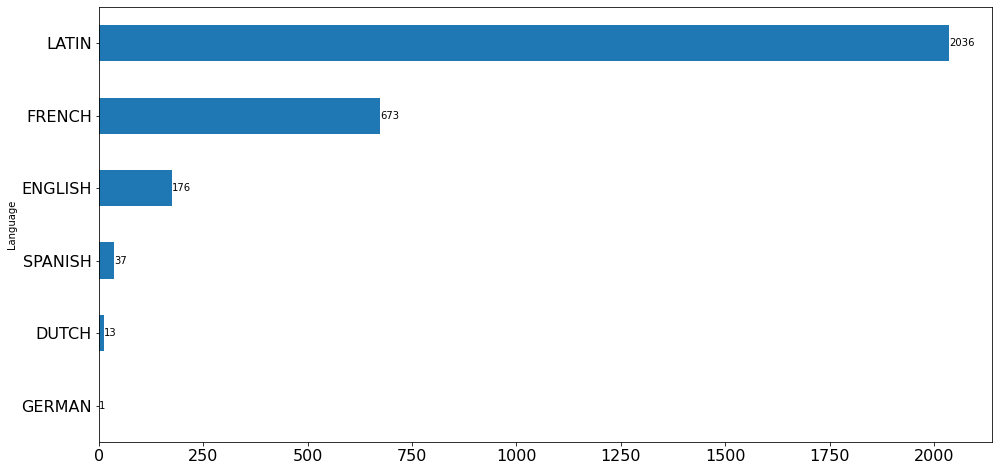

In [19]:
language_plot = pub['Language'].value_counts(ascending = True).plot.barh(figsize = (16, 8))
language_plot.tick_params(axis='x', labelsize = 16)
language_plot.tick_params(axis='y', labelsize = 16)

for container in language_plot.containers:
    language_plot.bar_label(container)

In [20]:
pub['Language'].value_counts(normalize = True).round(4)

Language
LATIN      0.6935
FRENCH     0.2292
ENGLISH    0.0599
SPANISH    0.0126
DUTCH      0.0044
GERMAN     0.0003
Name: proportion, dtype: float64

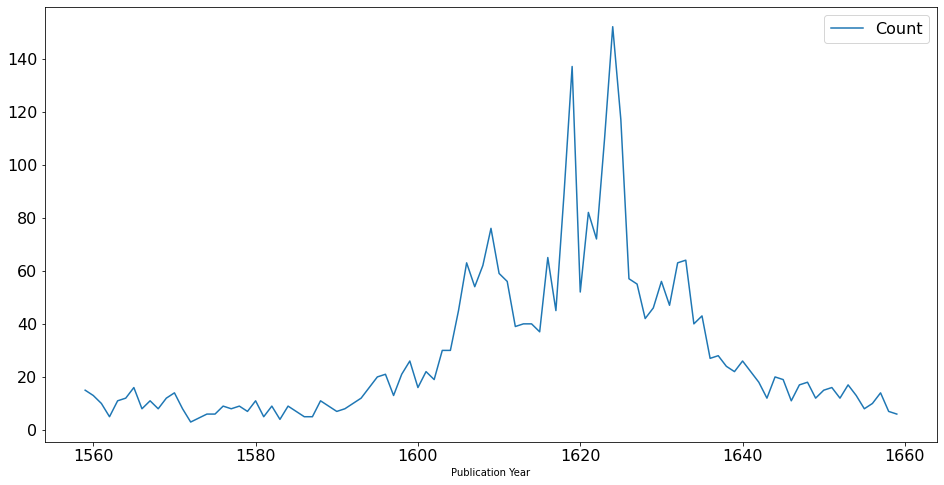

In [21]:
all_lan_counts = pub.groupby('Publication Year').size().reset_index(name = 'Count')
all_lan_counts_plot = all_lan_counts.plot.line(x = "Publication Year", y = "Count", figsize=(16, 8))
all_lan_counts_plot.tick_params(axis='x', labelsize = 16)
all_lan_counts_plot.tick_params(axis='y', labelsize = 16)
all_lan_counts_plot.legend(fontsize = 16)

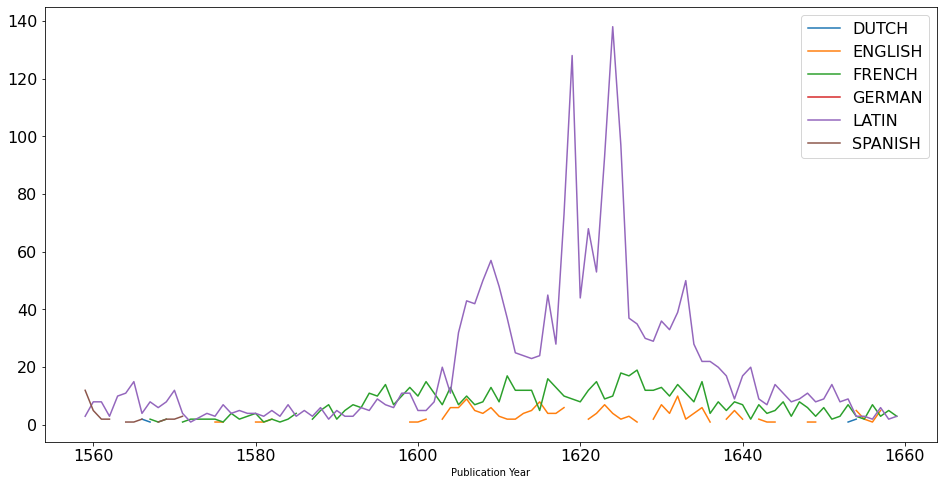

In [22]:
# in time trend
language_counts = pub.groupby(['Language', 'Publication Year']).size().reset_index(name = 'Count')
language_pivot = language_counts.pivot(index = 'Publication Year', columns = 'Language', values = 'Count')

language_pivot_plot = language_pivot.plot.line(figsize=(16, 8))
language_pivot_plot.tick_params(axis='x', labelsize = 16)
language_pivot_plot.tick_params(axis='y', labelsize = 16)
language_pivot_plot.legend(fontsize = 16)

In [23]:
from statsmodels.stats.proportion import proportions_ztest

In [24]:
def normalise(import_df):
    df = import_df.copy()
    for col in df.columns:
        col_sum = sum([num for num in df[col] if not pd.isnull(num)])
        col_list = []
        for num in df[col]:
            if not pd.isnull(num):
                col_list.append(num / col_sum)
            else:
                col_list.append(num)
        df[col] = col_list
    return df

In [25]:
def ztesting(df, df2):
    
    total_list = []
    for column in df.columns:
        total_list.append(sum([count for count in df[column] if not str(count) == 'nan']))
    
    df_new = df.copy()
    
    for i in range(0, len(df.columns)):
        result_list = []
        
        for row in range(0, len(df)):
            result_set = []
            
            if str(df[df.columns[i]][row]) == 'nan':
                result_list.append(None)
            else:
                for j in range(0, len(df.columns)):
                    if not i == j:
                        if str(df[df.columns[j]][row]) == 'nan':
                            result_set.append('n')
                        else:
                            z_score, p_value = proportions_ztest(
                                    [df[df.columns[i]][row], df[df.columns[j]][row]], [total_list[i], total_list[j]]
                                )
                            if p_value < 0.05:
                                if max([df2[df2.columns[i]][row], df2[df2.columns[j]][row]]) == df2[df2.columns[i]][row]:
                                    result_set.append(j)
                                else:
                                    result_set.append('')
                            else:
                                result_set.append('')

                result_list.append(result_set)
        
        df_new[df.columns[i]] = result_list
    
    return df_new

In [26]:
def insert_all(df):
    
    all_list = []
    for i in range(0, len(df)):
        all_list.append(sum([count for count in df.iloc[i] if not str(count) == 'nan']))
    df.insert(0, 'All', all_list)
    
    return df

In [27]:
rel_dist = rel[['ODIS_ID', 'ODIS_PERS_ID']].drop_duplicates()
rel_dist = pd.merge(rel_dist, pub[['ODIS_ID', 'Language', 'Publication Year']], on = 'ODIS_ID')
rel_dist = pd.merge(rel_dist, per[['ODIS_PERS_ID', 'Birth Region']], on = 'ODIS_PERS_ID')

In [28]:
rel_dist.head()

,ODIS_ID,ODIS_PERS_ID,Language,Publication Year,Birth Region
0,35786,119246,LATIN,1563.0,NaN
1,35914,119246,LATIN,1563.0,NaN
2,36812,119246,LATIN,1563.0,NaN
3,35786,119215,LATIN,1563.0,Low Countries
4,35914,119215,LATIN,1563.0,Low Countries


In [29]:
# cross table of birth region and involved languages
total_region = rel_dist.groupby(['Language', 'Birth Region']).size().unstack()
total_region = insert_all(total_region)

In [30]:
total_region

Birth Region,All,Britain,France,Genève,Holy Roman Empire,Iberian Union,Italy,Low Countries
Language,,,,,,,,
DUTCH,10.0,1.0,2.0,NaN,NaN,NaN,NaN,7.0
ENGLISH,273.0,120.0,11.0,NaN,1.0,10.0,6.0,125.0
FRENCH,1199.0,21.0,163.0,1.0,15.0,96.0,56.0,847.0
LATIN,2230.0,161.0,68.0,NaN,87.0,88.0,74.0,1752.0
SPANISH,15.0,NaN,NaN,NaN,NaN,13.0,NaN,2.0


In [31]:
total_region_pro = normalise(total_region)

In [32]:
total_region_pro.round(2)

Birth Region,All,Britain,France,Genève,Holy Roman Empire,Iberian Union,Italy,Low Countries
Language,,,,,,,,
DUTCH,0.00,0.00,0.01,NaN,NaN,NaN,NaN,0.00
ENGLISH,0.07,0.40,0.05,NaN,0.01,0.05,0.04,0.05
FRENCH,0.32,0.07,0.67,1.0,0.15,0.46,0.41,0.31
LATIN,0.60,0.53,0.28,NaN,0.84,0.43,0.54,0.64
SPANISH,0.00,NaN,NaN,NaN,NaN,0.06,NaN,0.00


In [33]:
ztesting(total_region, total_region_pro)

Birth Region,All,Britain,France,Genève,Holy Roman Empire,Iberian Union,Italy,Low Countries
Language,,,,,,,,
DUTCH,"[, , n, n, n, n, ]","[, , n, n, n, n, ]","[, , n, n, n, n, ]",None,None,None,None,"[, , , n, n, n, n]"
ENGLISH,"[, , n, 4, , , 7]","[0, 2, n, 4, 5, 6, 7]","[, , n, , , , ]",None,"[, , , n, , , ]","[, , , n, , , ]","[, , , n, , , ]","[, , , n, , , ]"
FRENCH,"[1, , , 4, , , ]","[, , , , , , ]","[0, 1, , 4, 5, 6, 7]","[, 1, , 4, , , ]","[, 1, , , , , ]","[0, 1, , , 4, , 7]","[0, 1, , , 4, , 7]","[, 1, , , 4, , ]"
LATIN,"[1, 2, n, , 5, , ]","[, 2, n, , 5, , ]","[, , n, , , , ]",None,"[0, 1, 2, n, 5, 6, 7]","[, , 2, n, , , ]","[, , 2, n, , 5, ]","[0, 1, 2, n, , 5, 6]"
SPANISH,"[n, n, n, n, , n, 7]",None,None,None,None,"[0, n, n, n, n, n, 7]",None,"[, n, n, n, n, , n]"


In [34]:
n_list = []
for col in total_region.columns:
    n_list.append(sum([i for i in total_region[col] if not str(i) == 'nan']))
n_list

[3727.0, 303.0, 244.0, 1.0, 103.0, 207.0, 136.0, 2733.0]

In [35]:
# z-test of Britain
z_score, p_value = proportions_ztest([120, 273], [303, 3727])
z_score, p_value

(18.214033866092098, 3.9940524960694496e-74)

In [36]:
# z-test of French
z_score, p_value = proportions_ztest([163, 1199], [244, 3727])
z_score, p_value

(11.040391107711159, 2.4396890829383765e-28)

In [37]:
# z-test of Latin (Holy Roman Empire)
z_score, p_value = proportions_ztest([87, 2223], [103, 3727])
z_score, p_value

(5.078962927320186, 3.795007484701319e-07)

In [38]:
# z-test of Spainish
z_score, p_value = proportions_ztest([13, 15], [136, 3727])
z_score, p_value

(12.364382443608752, 4.07329739675906e-35)

In [39]:
# z-test of Latin (Low Countries)
z_score, p_value = proportions_ztest([1752, 2228], [2733, 3727])
z_score, p_value

(3.5316214742922054, 0.00041302011227817417)

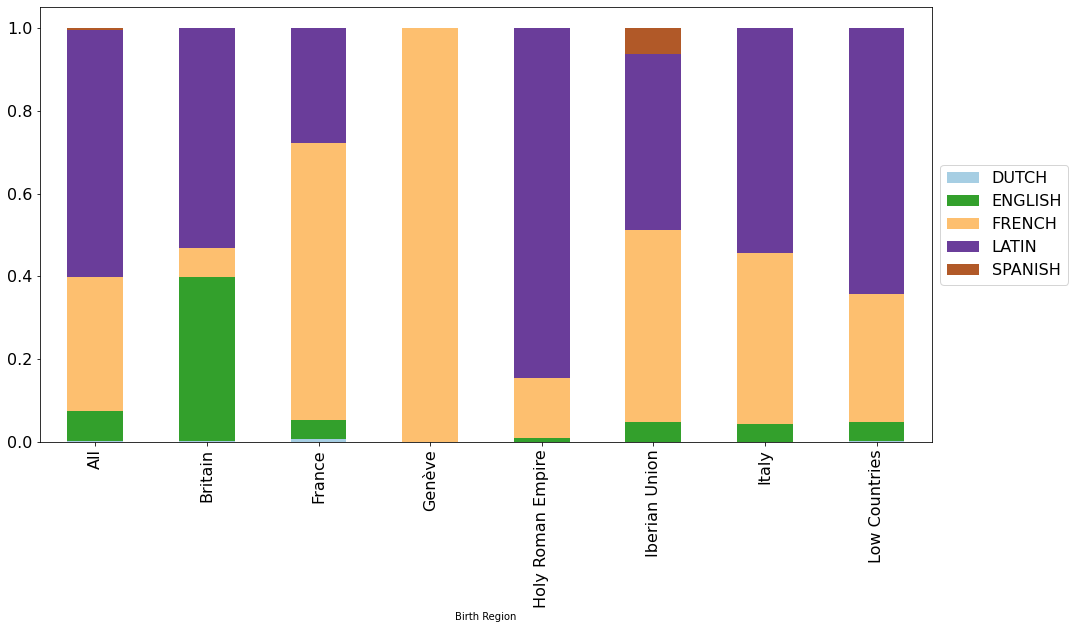

In [40]:
regionXlan = total_region_pro.T.plot.bar(stacked = True, figsize=(16, 8), colormap = 'Paired')
regionXlan.tick_params(axis='x', labelsize = 16)
regionXlan.tick_params(axis='y', labelsize = 16)
regionXlan.legend(fontsize = 16, loc='center left', bbox_to_anchor=(1.0, 0.5))

In [41]:
languages = list(set([lan for lan in rel_dist['Language'] if not lan == 'GERMAN']))
languages.sort()

In [42]:
languages

['DUTCH', 'ENGLISH', 'FRENCH', 'LATIN', 'SPANISH']

In [43]:
regions = ['All'] + list(set([region for region in rel_dist['Birth Region'] if not str(region) == 'nan']))
regions.sort()

In [44]:
regions

['All',
 'Britain',
 'France',
 'Genève',
 'Holy Roman Empire',
 'Iberian Union',
 'Italy',
 'Low Countries']

In [45]:
per.groupby('Birth Region').count()['ODIS_PERS_ID']

Birth Region
Britain               60
France                56
Genève                 1
Holy Roman Empire     15
Iberian Union         29
Italy                 40
Low Countries        202
Name: ODIS_PERS_ID, dtype: int64

In [46]:
sum(per.groupby('Birth Region').count()['ODIS_PERS_ID'])

403

In [47]:
lanXregion_dist = {}
for region in regions:
    lanXregion_dist[region] = {}
    for lan in languages:
        if region == 'All':
            temp_df = rel_dist.loc[(rel_dist['Language'] == lan) & (rel_dist['Birth Region'].notna())]
            lanXregion_dist[region][lan] = len(list(set([ID for ID in temp_df['ODIS_PERS_ID']])))
        else:
            temp_df = rel_dist.loc[(rel_dist['Birth Region'] == region) & (rel_dist['Language'] == lan)]
            lanXregion_dist[region][lan] = len(list(set([ID for ID in temp_df['ODIS_PERS_ID']])))

In [48]:
for region in lanXregion_dist:
    total_region[region] = [count for lan, count in lanXregion_dist[region].items()]

In [49]:
total_region

Birth Region,All,Britain,France,Genève,Holy Roman Empire,Iberian Union,Italy,Low Countries
Language,,,,,,,,
DUTCH,7,1,2,0,0,0,0,4
ENGLISH,74,38,6,0,1,6,4,19
FRENCH,204,8,43,1,9,12,23,108
LATIN,293,39,24,0,12,23,24,171
SPANISH,6,0,0,0,0,4,0,2


In [50]:
n_list = [sum(per.groupby('Birth Region').count()['ODIS_PERS_ID'])] + [count for count in per.groupby('Birth Region').count()['ODIS_PERS_ID']]
for i in range(0, len(total_region_pro.columns)):
    temp_list = [count / n_list[i] for count in total_region[total_region_pro.columns[i]]]
    total_region_pro[total_region_pro.columns[i]] = temp_list

In [51]:
total_region_pro.round(2)

Birth Region,All,Britain,France,Genève,Holy Roman Empire,Iberian Union,Italy,Low Countries
Language,,,,,,,,
DUTCH,0.02,0.02,0.04,0.0,0.00,0.00,0.00,0.02
ENGLISH,0.18,0.63,0.11,0.0,0.07,0.21,0.10,0.09
FRENCH,0.51,0.13,0.77,1.0,0.60,0.41,0.57,0.53
LATIN,0.73,0.65,0.43,0.0,0.80,0.79,0.60,0.85
SPANISH,0.01,0.00,0.00,0.0,0.00,0.14,0.00,0.01


In [52]:
def ztesting2(df, df2):
    
#     total_list = []
#     for column in df.columns:
#         total_list.append(sum([count for count in df[column] if not str(count) == 'nan']))
    
    df_new = df.copy()
    
    for i in range(0, len(df.columns)):
        result_list = []
        
        for row in range(0, len(df)):
            result_set = []
            
            if str(df[df.columns[i]][row]) == 'nan':
                result_list.append(None)
            else:
                for j in range(0, len(df.columns)):
                    if not i == j:
                        if str(df[df.columns[j]][row]) == 'nan':
                            result_set.append('n')
                        else:
                            z_score, p_value = proportions_ztest(
                                    [df[df.columns[i]][row], df[df.columns[j]][row]], [total_list[i], total_list[j]]
                                )
                            if p_value < 0.05:
                                if max([df2[df2.columns[i]][row], df2[df2.columns[j]][row]]) == df2[df2.columns[i]][row]:
                                    result_set.append(j)
                                else:
                                    result_set.append('')
                            else:
                                result_set.append('')

                result_list.append(result_set)
        
        df_new[df.columns[i]] = result_list
    
    return df_new

In [53]:
total_list = n_list

In [54]:
ztesting2(total_region, total_region_pro)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\weightstats.py:790: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std


Birth Region,All,Britain,France,Genève,Holy Roman Empire,Iberian Union,Italy,Low Countries
Language,,,,,,,,
DUTCH,"[, , , , , , ]","[, , , , , , ]","[, , , , , , ]","[, , , , , , ]","[, , , , , , ]","[, , , , , , ]","[, , , , , , ]","[, , , , , , ]"
ENGLISH,"[, , , , , , 7]","[0, 2, , 4, 5, 6, 7]","[, , , , , , ]","[, , , , , , ]","[, , , , , , ]","[, , , , , , ]","[, , , , , , ]","[, , , , , , ]"
FRENCH,"[1, , , , , , ]","[, , , , , , ]","[0, 1, , , 5, 6, 7]","[, 1, , , , , ]","[, 1, , , , , ]","[, 1, , , , , ]","[, 1, , , , , ]","[, 1, , , , , ]"
LATIN,"[, 2, , , , , ]","[, 2, , , , , ]","[, , , , , , ]","[, , , , , , ]","[, , 2, , , , ]","[, , 2, , , , ]","[, , , , , , ]","[0, 1, 2, 3, , , 6]"
SPANISH,"[, , , , , , ]","[, , , , , , ]","[, , , , , , ]","[, , , , , , ]","[, , , , , , ]","[0, 1, 2, , , 6, 7]","[, , , , , , ]","[, , , , , , ]"


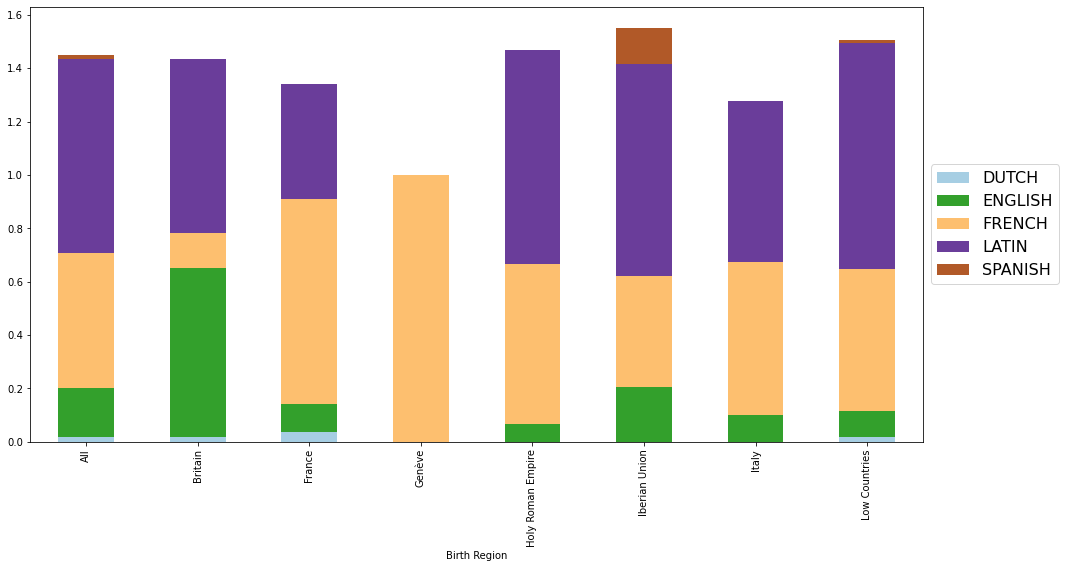

In [55]:
total_region_pro.T.plot.bar(stacked = True, figsize=(16, 8), colormap = 'Paired').legend(fontsize = 16, loc='center left', bbox_to_anchor=(1.0, 0.5))

In [56]:
# z-test of Britain
z_score, p_value = proportions_ztest([38, 36], [60, 343])
z_score, p_value, p_value < 0.05

(9.752261940496561, 1.804030778680607e-22, True)

In [57]:
# z-test of French
z_score, p_value = proportions_ztest([43, 161], [56, 347])
z_score, p_value, p_value < 0.05

(4.220579179592543, 2.4367544814937677e-05, True)

In [58]:
# z-test of Spainish
z_score, p_value = proportions_ztest([4, 2], [29, 374])
z_score, p_value, p_value < 0.05

(5.67944280719403, 1.3513422476138224e-08, True)

In [59]:
# z-test of Latin
z_score, p_value = proportions_ztest([171, 122], [202, 201])
z_score, p_value, p_value < 0.05

(5.397934032050138, 6.741264331613302e-08, True)

<AxesSubplot:xlabel='Publication Year'>

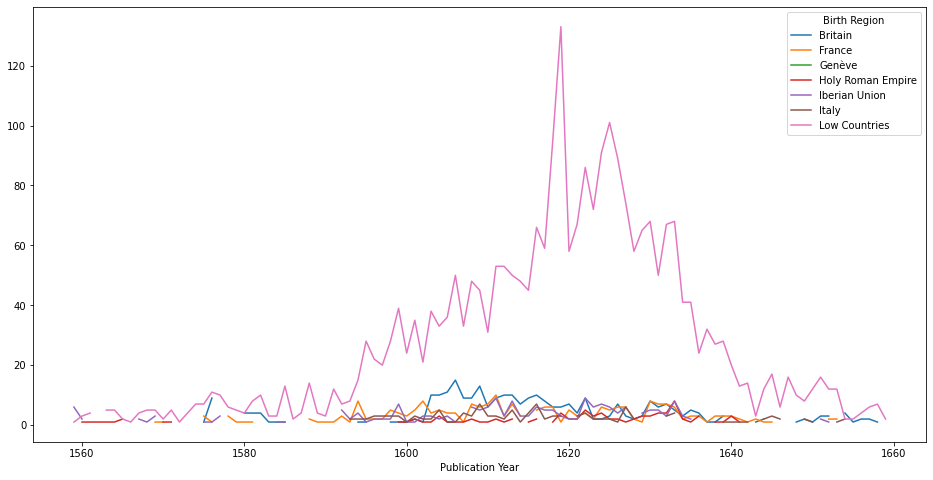

In [60]:
# region in time trend
region_counts = rel_dist.groupby(['Birth Region', 'Publication Year']).size().reset_index(name = 'Count')
region_pivot = region_counts.pivot(index = 'Publication Year', columns = 'Birth Region', values='Count')
region_pivot.plot.line(figsize=(16, 8))

Network metrics

In [61]:
import networkx as nx
from scipy.stats import ttest_ind

In [62]:
sna_cal = pd.read_csv('sna/data/people_cal.csv')

In [63]:
all_network_node = pd.read_csv('sna/data/people_node.csv')
all_network_edge = pd.read_csv('sna/data/people_edge.csv')

In [64]:
du_network_node = all_network_node.loc[all_network_node['DUTCH'] > 0].reset_index(drop = True)
du_network_edge = all_network_edge.loc[all_network_edge['Language'] == 'DUTCH'].reset_index(drop = True)

In [65]:
en_network_node = all_network_node.loc[all_network_node['ENGLISH'] > 0].reset_index(drop = True)
en_network_edge = all_network_edge.loc[all_network_edge['Language'] == 'ENGLISH'].reset_index(drop = True)

In [66]:
nonen_network_node = all_network_node.loc[all_network_node['ENGLISH'] == 0].reset_index(drop = True)
nonen_network_edge = all_network_edge.loc[all_network_edge['Language'] != 'ENGLISH'].reset_index(drop = True)

In [67]:
fr_network_node = all_network_node.loc[all_network_node['FRENCH'] > 0].reset_index(drop = True)
fr_network_edge = all_network_edge.loc[all_network_edge['Language'] == 'FRENCH'].reset_index(drop = True)

In [68]:
la_network_node = all_network_node.loc[all_network_node['LATIN'] > 0].reset_index(drop = True)
la_network_edge = all_network_edge.loc[all_network_edge['Language'] == 'LATIN'].reset_index(drop = True)

In [69]:
sp_network_node = all_network_node.loc[all_network_node['SPANISH'] > 0].reset_index(drop = True)
sp_network_edge = all_network_edge.loc[all_network_edge['Language'] == 'SPANISH'].reset_index(drop = True)

In [70]:
period = [p for p in all_network_edge['Publication Period'].drop_duplicates()]
period.sort()
period = ['All'] + period

In [71]:
period

['All',
 '1550s',
 '1560s',
 '1570s',
 '1580s',
 '1590s',
 '1600s',
 '1610s',
 '1620s',
 '1630s',
 '1640s',
 '1650s']

In [72]:
periods = list(set([p for p in meta['Publication Period']]))
periods.sort()

In [73]:
languages = [l for l in all_network_edge['Language'].drop_duplicates()]
languages.sort()
languages = ['All'] + languages

In [74]:
languages

['All', 'DUTCH', 'ENGLISH', 'FRENCH', 'LATIN', 'SPANISH']

In [75]:
def ttesting(df, df2):
    
    df_new = df.copy()
    
    for i in range(0, len(df.columns)):
        result_list = []
        
        for row in range(0, len(df)):
            result_set = []
            
            if df[df.columns[i]][row] == None:
                result_list.append(None)
            else:
                for j in range(0, len(df.columns)):
                    if not i == j:
                        if df[df.columns[j]][row] == None:
                            result_set.append('n')
                        else:
                            t_statistic, p_value = ttest_ind(list(df[df.columns[i]][row]), list(df[df.columns[j]][row]))
                            if p_value < 0.05:
                                if max([df2[df2.columns[i]][row], df2[df2.columns[j]][row]]) == df2[df2.columns[i]][row]:
                                    result_set.append(j)
                                else:
                                    result_set.append('')
                            else:
                                result_set.append('')

                result_list.append(result_set)
        
        df_new[df.columns[i]] = result_list
    
    return df_new

In [76]:
def calculation(df):
    df_cal1 = df.copy()
    df_cal2 = df.copy()
    for col in df.columns:
        col_cal1 = []
        col_cal2 = []
        for item in df[col]:
            if len(item) == 0:
                col_cal1.append(None)
                col_cal2.append(None)
            else:
                col_cal1.append(sum(dict(item).values()) / len(item))
                col_cal2.append(dict(item).values())
        df_cal1[col] = col_cal1
        df_cal2[col] = col_cal2
        
    return df_cal1, df_cal2

In [77]:
# calculate degree centrality
G_degree = nx.Graph()
edge_list = [
            (all_network_edge['Source'][i], all_network_edge['Target'][i])
            for i in range(0, len(all_network_edge))
        ]
G_degree.add_edges_from(edge_list)
degree_full = nx.degree_centrality(G_degree)

In [78]:
degree_df = pd.DataFrame()
degree_list = pd.DataFrame()
degree_df['Period'] = period
degree_list['Period'] = period

for l in languages:
    degree_lan = []
    degree_num = []
    
    if l == 'All':
        temp_df = all_network_edge
    else:
        temp_df = all_network_edge.loc[all_network_edge['Language'] == l].reset_index(drop = True)
    id_list = [ID for ID in temp_df['Source']] + [ID for ID in temp_df['Target']]
    id_list = list(set(id_list))
    degree_all = [degree_full[ID] for ID in id_list]
    degree_num.append(degree_all)
    
    if len(degree_all) == 0:
        degree_lan.append(0)
    else:
        degree_lan.append(sum(degree_all) / len(degree_all))
    
    for p in period[1:]:
        temp_df_p = temp_df.loc[temp_df['Publication Period'] == p].reset_index(drop = True)
        id_list_p = [ID for ID in temp_df_p['Source']] + [ID for ID in temp_df_p['Target']]
        id_list_p = list(set(id_list_p))
        degree_all_p = [degree_full[ID] for ID in id_list_p]
        degree_num.append(degree_all_p)
        
        if len(degree_all_p) == 0:
            degree_lan.append(0)
        else:
            degree_lan.append(sum(degree_all_p) / len(degree_all_p))
    
    degree_df[l] = degree_lan
    degree_list[l] = degree_num

degree_df = degree_df.set_index('Period')
degree_list = degree_list.set_index('Period')

In [79]:
degree_df.round(4)

,All,DUTCH,ENGLISH,FRENCH,LATIN,SPANISH
Period,,,,,,
All,0.0036,0.0286,0.0126,0.0069,0.0040,0.0136
1550s,0.0073,0.0000,0.0000,0.0000,0.0081,0.0087
1560s,0.0041,0.0117,0.0000,0.0110,0.0042,0.0059
1570s,0.0087,0.0465,0.0232,0.0147,0.0080,0.0069
1580s,0.0097,0.0049,0.0011,0.0139,0.0110,0.0000
1590s,0.0102,0.0000,0.0000,0.0124,0.0162,0.0767
1600s,0.0060,0.0000,0.0146,0.0110,0.0070,0.0115
1610s,0.0065,0.0000,0.0159,0.0127,0.0070,0.0000
1620s,0.0055,0.0177,0.0241,0.0124,0.0061,0.0188


In [80]:
ttesting(degree_list, degree_df)

,All,DUTCH,ENGLISH,FRENCH,LATIN,SPANISH
Period,,,,,,
All,"[, , , , ]","[0, , 3, 4, ]","[0, , 3, 4, ]","[0, , , 4, ]","[, , , , ]","[0, , , , 4]"
1550s,"[, , , , ]","[, , , , ]","[, , , , ]","[, , , , ]","[, , , , ]","[, , , , ]"
1560s,"[, , , , ]","[0, , , 4, ]","[, , , , ]","[0, , , 4, ]","[, , , , ]","[, , , , ]"
1570s,"[, , , , ]","[0, , 3, 4, ]","[, , , , ]","[, , , , ]","[, , , , ]","[, , , , ]"
1580s,"[, , , , ]","[, , , , ]","[, , , , ]","[, , , , ]","[, , , , ]","[, , , , ]"
1590s,"[, , , , ]","[, , , , ]","[, , , , ]","[, , , , ]","[, , , , ]","[0, , , 3, ]"
1600s,"[, , , , ]","[, , , , ]","[0, , , 4, ]","[0, , , , ]","[, , , , ]","[, , , , ]"
1610s,"[, , , , ]","[, , , , ]","[0, , , 4, ]","[0, , , 4, ]","[, , , , ]","[, , , , ]"
1620s,"[, , , , ]","[, , , , ]","[0, , 3, 4, ]","[0, , , 4, ]","[, , , , ]","[, , , , ]"


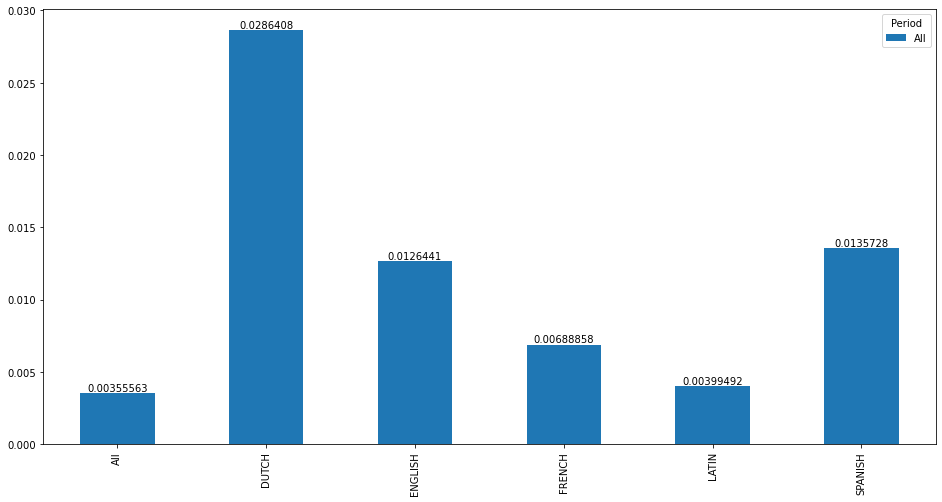

In [81]:
degree_plot = degree_df.iloc[:1].T.plot.bar(figsize = (16, 8))

for container in degree_plot.containers:
    degree_plot.bar_label(container)

<AxesSubplot:xlabel='Period'>

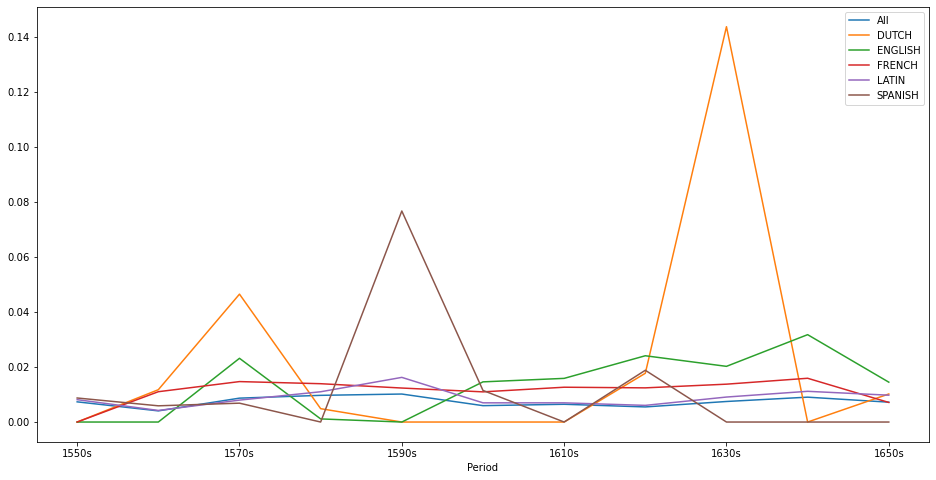

In [82]:
degree_df.iloc[1:].plot.line(figsize = (16, 8))

<AxesSubplot:xlabel='Period'>

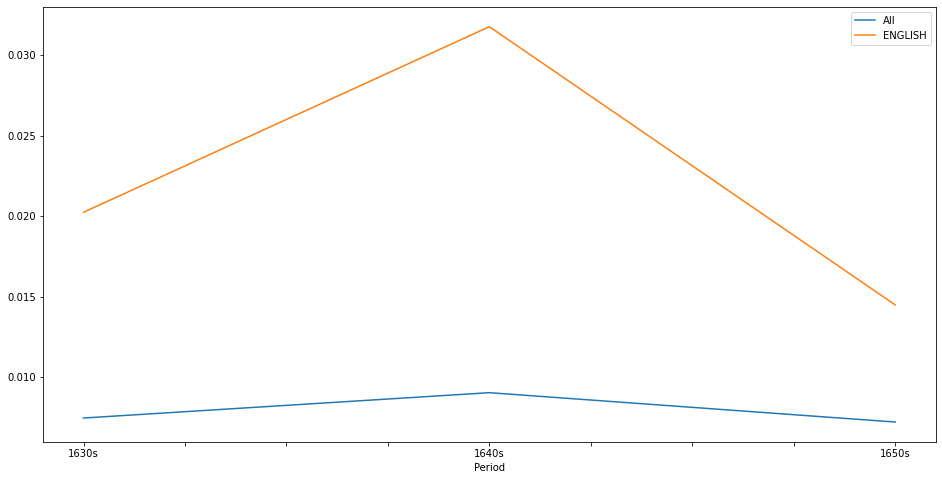

In [83]:
degree_df.iloc[9:][['All', 'ENGLISH']].plot.line(figsize = (16, 8))

In [84]:
degree_df.T

Period,All,1550s,1560s,1570s,1580s,1590s,1600s,1610s,1620s,1630s,1640s,1650s
All,0.003556,0.007335,0.004054,0.008685,0.009700,0.010176,0.005952,0.006454,0.005490,0.007467,0.009040,0.007218
DUTCH,0.028641,0.000000,0.011748,0.046481,0.004854,0.000000,0.000000,0.000000,0.017718,0.143689,0.000000,0.010194
ENGLISH,0.012644,0.000000,0.000000,0.023162,0.001133,0.000000,0.014600,0.015867,0.024088,0.020238,0.031756,0.014488
FRENCH,0.006889,0.000000,0.011022,0.014700,0.013930,0.012357,0.010964,0.012652,0.012421,0.013761,0.015908,0.007117
LATIN,0.003995,0.008131,0.004211,0.007966,0.011000,0.016229,0.006980,0.006974,0.006056,0.009083,0.011165,0.009755
SPANISH,0.013573,0.008738,0.005895,0.006857,0.000000,0.076699,0.011489,0.000000,0.018811,0.000000,0.000000,0.000000


In [85]:
ttesting(degree_list.T, degree_df.T)

Period,All,1550s,1560s,1570s,1580s,1590s,1600s,1610s,1620s,1630s,1640s,1650s
All,"[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[0, , 2, , , , , , , , ]","[0, , 2, , , , , 8, , , ]","[0, , 2, , , 6, 7, 8, , , ]","[0, , , , , , , , , , ]","[0, , , , , , , , , , ]","[0, , , , , , , , , , ]","[0, , , , , , , , , , ]","[0, , , , , , , , 8, , ]","[0, , 2, , , , , , , , ]"
DUTCH,"[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[0, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]"
ENGLISH,"[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[0, , , , , , , , , , ]","[, , , , , , , , , , ]"
FRENCH,"[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[0, , , , , , , , , , 11]","[0, , , , , , , , , , ]","[0, , , , , , , , , , ]","[0, , , , , , , , , , ]","[0, , , , , , , , , , ]","[0, , , , , , , , , , ]","[0, , , , , , , , , , ]","[0, , , , , , , , , , ]","[, , , , , , , , , , ]"
LATIN,"[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[0, , , , , , , , , , ]","[0, , 2, , , , , , , , ]","[0, , 2, , , 6, 7, 8, 9, , ]","[0, , , , , , , , , , ]","[0, , , , , , , , , , ]","[0, , , , , , , , , , ]","[0, , , , , , , , 8, , ]","[0, , 2, , , , , , 8, , ]","[0, , 2, , , , , , , , ]"
SPANISH,"[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[0, , 2, 3, , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]"


In [86]:
# calculate closeness centrality
G_close = nx.Graph()
edge_list = [
            (all_network_edge['Source'][i], all_network_edge['Target'][i])
            for i in range(0, len(all_network_edge))
        ]
G_close.add_edges_from(edge_list)
closeness_full = nx.closeness_centrality(G_close)

In [88]:
close_cal_list = []
for period in periods:
    G_close = nx.Graph()
    close_df = all_network_edge.loc[all_network_edge['Publication Period'] == period].reset_index(drop = True)
    edge_list = [
                (close_df['Source'][i], close_df['Target'][i])
                for i in range(0, len(close_df))
            ]
    G_close.add_edges_from(edge_list)
    closeness = nx.closeness_centrality(G_close)
    close_cal_list.append(closeness)

In [89]:
closeness_df = pd.DataFrame()
closeness_list = pd.DataFrame()
closeness_df['Period'] = ['All'] + periods
closeness_list['Period'] = ['All'] + periods

for l in languages:
    closeness_lan = []
    closeness_num = []
    
    if l == 'All':
        temp_df = all_network_edge
    else:
        temp_df = all_network_edge.loc[all_network_edge['Language'] == l].reset_index(drop = True)
    id_list = [ID for ID in temp_df['Source']] + [ID for ID in temp_df['Target']]
    id_list = list(set(id_list))
    closeness_all = [closeness_full[ID] for ID in id_list]
    closeness_num.append(closeness_all)
    
    if len(closeness_all) == 0:
        closeness_lan.append(0)
    else:
        closeness_lan.append(sum(closeness_all) / len(closeness_all))
    
    for i in range(0, len(periods)):
        temp_df_p = temp_df.loc[temp_df['Publication Period'] == periods[i]].reset_index(drop = True)
        id_list_p = [ID for ID in temp_df_p['Source']] + [ID for ID in temp_df_p['Target']]
        id_list_p = list(set(id_list_p))
        closeness_all_p = [close_cal_list[i][ID] for ID in id_list_p]
        closeness_num.append(closeness_all_p)
        
        if len(closeness_all_p) == 0:
            closeness_lan.append(0)
        else:
            closeness_lan.append(sum(closeness_all_p) / len(closeness_all_p))
    
    closeness_df[l] = closeness_lan
    closeness_list[l] = closeness_num

closeness_df = closeness_df.set_index('Period')
closeness_list = closeness_list.set_index('Period')

In [90]:
closeness_df.round(2)

,All,DUTCH,ENGLISH,FRENCH,LATIN,SPANISH
Period,,,,,,
All,0.31,0.32,0.33,0.33,0.31,0.28
1550s,0.59,0.00,0.00,0.00,0.65,0.61
1560s,0.23,0.22,0.00,0.15,0.23,0.28
1570s,0.37,0.51,0.40,0.43,0.36,0.18
1580s,0.44,0.01,0.01,0.45,0.48,0.00
1590s,0.40,0.00,0.00,0.41,0.40,0.53
1600s,0.33,0.00,0.30,0.35,0.33,0.34
1610s,0.29,0.00,0.32,0.31,0.29,0.00
1620s,0.32,0.35,0.33,0.34,0.32,0.32


In [92]:
# closeness_df = pd.DataFrame()
# closeness_df['Period'] = period
# for lan in languages:
#     closeness_df[lan] = closeness(all_network_node, all_network_edge, lan)
# closeness_df = closeness_df.set_index('Period')

In [93]:
ttesting(closeness_list, closeness_df)

C:\Users\User\AppData\Local\Temp\ipykernel_15644\1464152683.py:19: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_statistic, p_value = ttest_ind(list(df[df.columns[i]][row]), list(df[df.columns[j]][row]))


,All,DUTCH,ENGLISH,FRENCH,LATIN,SPANISH
Period,,,,,,
All,"[, , , , 5]","[, , , , ]","[0, , , 4, 5]","[0, , , 4, 5]","[, , , , 5]","[, , , , ]"
1550s,"[, , , , ]","[, , , , ]","[, , , , ]","[, , , , ]","[, , , , ]","[, , , , ]"
1560s,"[, , 3, , ]","[, , 3, , ]","[, , , , ]","[, , , , ]","[, , , 3, ]","[0, , , 3, 4]"
1570s,"[, , , , 5]","[0, , 3, 4, 5]","[, , , , 5]","[0, , , 4, 5]","[, , , , 5]","[, , , , ]"
1580s,"[1, 2, , , ]","[, , , , ]","[, , , , ]","[, 1, 2, , ]","[0, 1, 2, , ]","[, , , , ]"
1590s,"[, , , , ]","[, , , , ]","[, , , , ]","[, , , , ]","[, , , , ]","[0, , , 3, 4]"
1600s,"[, 2, , , ]","[, , , , ]","[, , , , ]","[0, , 2, 4, ]","[, , 2, , ]","[, , , , ]"
1610s,"[, , , , ]","[, , , , ]","[0, , , 4, ]","[0, , , 4, ]","[, , , , ]","[, , , , ]"
1620s,"[, , , , ]","[, , , , ]","[0, , , 4, ]","[0, , , 4, ]","[, , , , ]","[, , , , ]"


In [94]:
ttesting(closeness_list.T, closeness_df.T)

C:\Users\User\AppData\Local\Temp\ipykernel_15644\1464152683.py:19: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_statistic, p_value = ttest_ind(list(df[df.columns[i]][row]), list(df[df.columns[j]][row]))


Period,All,1550s,1560s,1570s,1580s,1590s,1600s,1610s,1620s,1630s,1640s,1650s
All,"[, 2, , , , , 7, , , 10, 11]","[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","[, , , , , , , , , , ]","[0, , 2, , , 6, 7, 8, 9, 10, 11]","[0, , 2, 3, 5, 6, 7, 8, 9, 10, 11]","[0, , 2, 3, , 6, 7, 8, 9, 10, 11]","[0, , 2, , , , 7, 8, , 10, 11]","[, , 2, , , , , , , 10, 11]","[0, , 2, , , , , 7, , 10, 11]","[0, , 2, , , , 6, 7, 8, 10, 11]","[, , 2, , , , , , , , ]","[, , 2, , , , , , , , ]"
DUTCH,"[, 2, , 4, , , , , , , 11]","[, , , , , , , , , , ]","[, , , 4, , , , , , , ]","[0, , 2, 4, , , , , , , 11]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , 4, , , , , , ]","[0, , 2, , 4, , , , , , 11]","[, , , , , , , , , , ]","[, , , , , , , , , , ]"
ENGLISH,"[, , , 4, , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[0, , , 4, , 6, 7, , , 10, 11]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , 4, , , , , , ]","[, , , , 4, , , , , , ]","[, , , , 4, , , , , , ]","[0, , , , 4, , 6, 7, , , 11]","[, , , , 4, , , , , , ]","[, , , , 4, , , , , , ]"
FRENCH,"[, 2, , , , , 7, , , 10, 11]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[0, , 2, , 5, 6, 7, 8, 9, 10, 11]","[0, , 2, , 5, 6, 7, 8, 9, 10, 11]","[0, , 2, , , 6, 7, 8, 9, 10, 11]","[0, , 2, , , , 7, , , 10, 11]","[, , 2, , , , , , , 10, 11]","[0, , 2, , , , , 7, , 10, 11]","[, , 2, , , , , 7, , 10, 11]","[, , 2, , , , , , , , ]","[, , 2, , , , , , , , ]"
LATIN,"[, 2, , , , , 7, , , 10, 11]","[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","[, , , , , , , , , , ]","[0, , 2, , , 6, 7, 8, 9, 10, 11]","[0, , 2, 3, 5, 6, 7, 8, 9, 10, 11]","[0, , 2, 3, , 6, 7, 8, 9, 10, 11]","[0, , 2, , , , 7, 8, , 10, 11]","[, , 2, , , , , , , 10, ]","[0, , 2, , , , , 7, , 10, 11]","[0, , 2, , , , 6, 7, 8, 10, 11]","[, , , , , , , , , , ]","[, , 2, , , , , , , , ]"
SPANISH,"[, , 3, , , , , , , , ]","[0, 2, 3, , , , , 8, , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[0, , 2, 3, , , , 8, , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]"


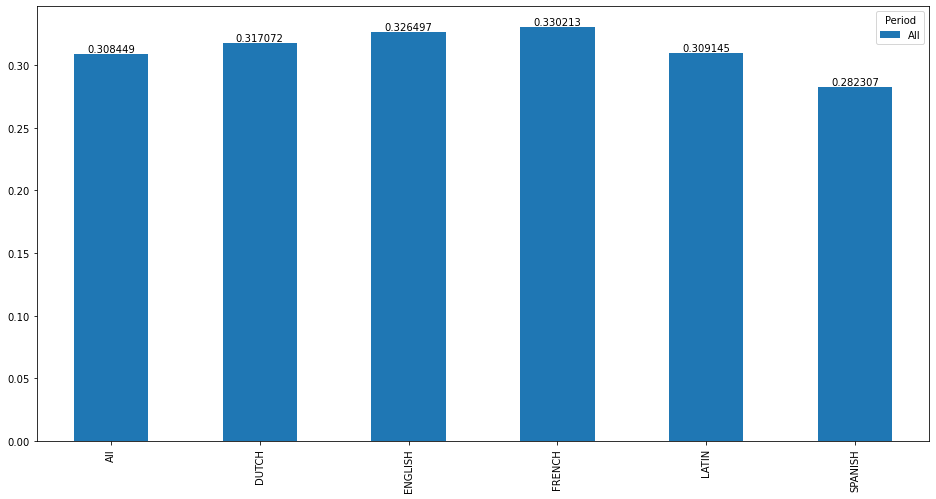

In [95]:
closeness_plot = closeness_df.iloc[:1].T.plot.bar(figsize = (16, 8))

for container in closeness_plot.containers:
    closeness_plot.bar_label(container)

<AxesSubplot:xlabel='Period'>

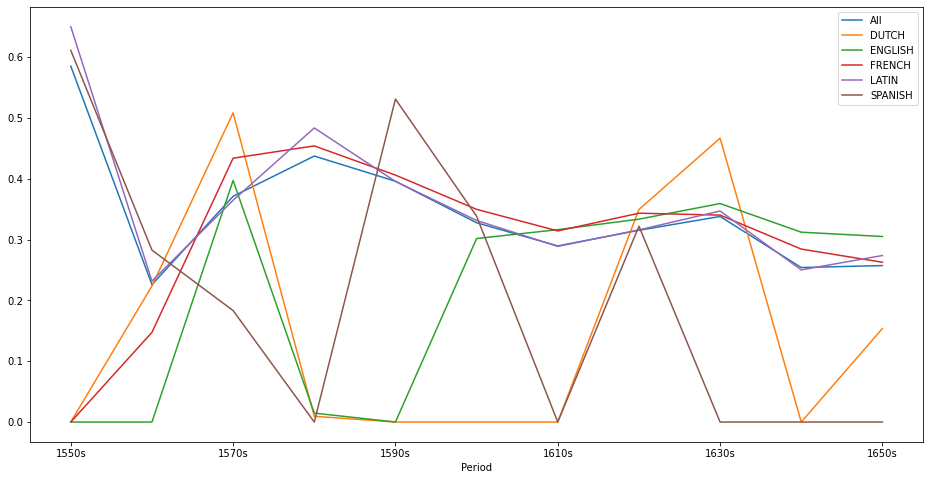

In [96]:
closeness_df.iloc[1:].plot.line(figsize = (16, 8))

<AxesSubplot:xlabel='Period'>

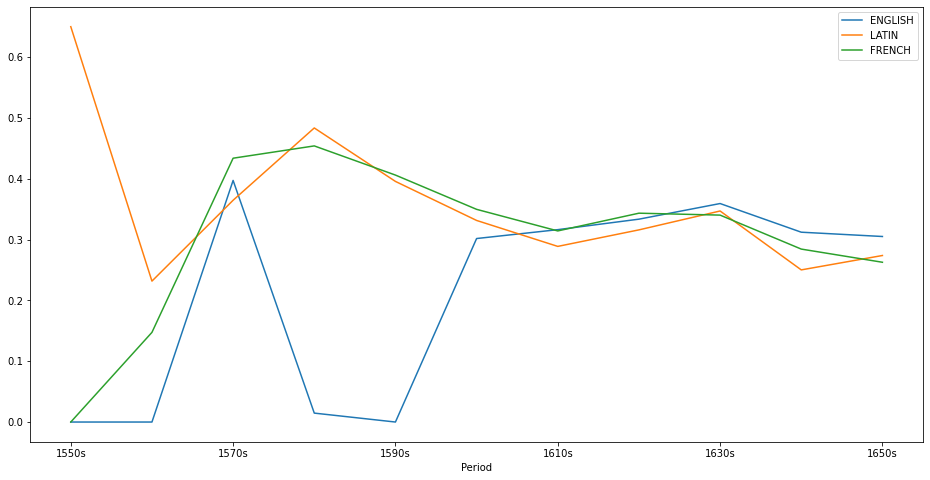

In [97]:
closeness_df.iloc[1:][['ENGLISH', 'LATIN','FRENCH']].plot.line(figsize = (16, 8))

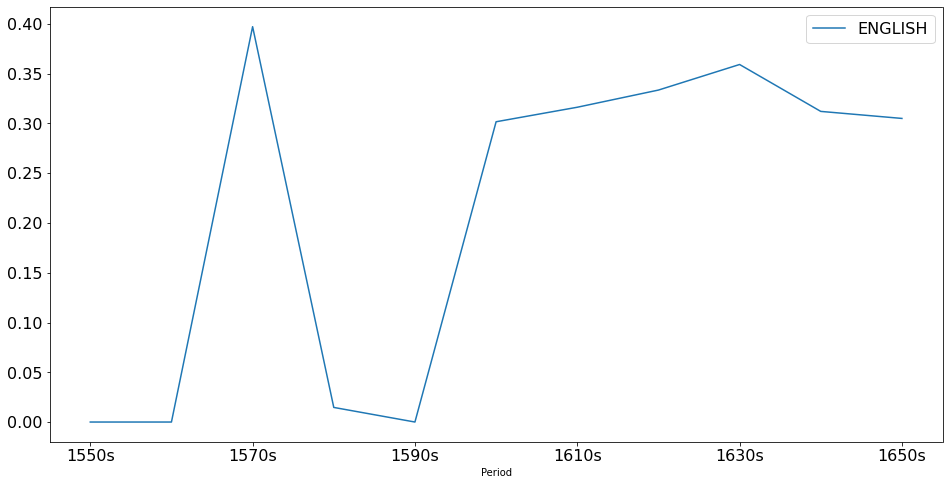

In [98]:
close_plot = closeness_df.iloc[1:][['ENGLISH']].plot.line(figsize = (16, 8))
close_plot.tick_params(axis='x', labelsize = 16)
close_plot.tick_params(axis='y', labelsize = 16)
close_plot.legend(fontsize = 16)

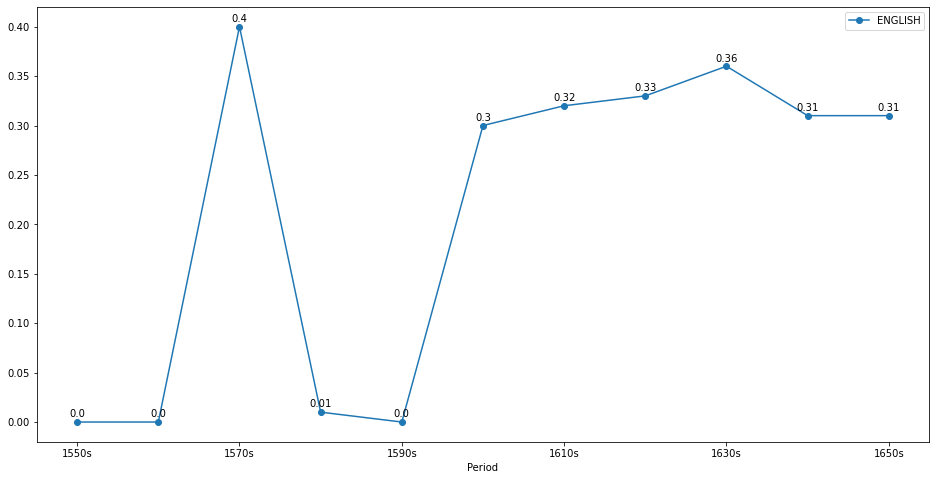

In [99]:
closeness_df_line = closeness_df.iloc[1:][['ENGLISH']].round(2)
closeness_line = closeness_df_line.plot.line(figsize = (16, 8), marker = 'o', linestyle = '-')

for column in closeness_df_line.columns:
    for i, value in enumerate(closeness_df_line[column]):
        closeness_line.annotate(value, (i, value), textcoords = "offset points", xytext = (0, 5), ha = 'center')

In [100]:
nodes_list = [ID for ID in closeness_full]
only_nodes = per.loc[per['ODIS_PERS_ID'].isin(nodes_list)]
only_en = per.loc[(per['ENGLISH'] > 0) & (per['ODIS_PERS_ID'].isin(nodes_list))]
en_id_list = [ID for ID in only_en['ODIS_PERS_ID']]
nonen_id_list = [ID for ID in only_nodes['ODIS_PERS_ID'] if not ID in en_id_list]

In [101]:
closeness_en_df = pd.DataFrame()
closeness_en_list = pd.DataFrame()
closeness_en_df['Period'] = ['All'] + periods
closeness_en_list['Period'] = ['All'] + periods

closeness_en_lan = []
closeness_nonen_lan = []

closeness_en_num = []
closeness_nonen_num = []

closeness_en_all = [closeness_full[ID] for ID in en_id_list]
closeness_en_num.append(closeness_en_all)

closeness_nonen_all = [closeness_full[ID] for ID in nonen_id_list]
closeness_nonen_num.append(closeness_nonen_all)


if len(closeness_en_all) == 0:
    closeness_en_lan.append(0)
else:
    closeness_en_lan.append(sum(closeness_en_all) / len(closeness_en_all))
    
if len(closeness_nonen_all) == 0:
    closeness_nonen_lan.append(0)
else:
    closeness_nonen_lan.append(sum(closeness_nonen_all) / len(closeness_nonen_all))

for i in range(0, len(periods)):
    temp_df = all_network_edge.loc[all_network_edge['Publication Period'] == periods[i]]
    temp_id = [ID for ID in temp_df['Source']] + [ID for ID in temp_df['Target']]
    temp_id = list(set(temp_id))
    
    temp_en_df = temp_df.loc[temp_df['Language'] == 'ENGLISH']
    temp_en_id = [ID for ID in temp_en_df['Source']] + [ID for ID in temp_en_df['Target']]
    temp_en_id = list(set(temp_en_id))
    temp_nonen_id = [ID for ID in temp_id if not ID in temp_en_id]
    
    closeness_en_all_p = [close_cal_list[i][ID] for ID in temp_en_id]
    closeness_en_num.append(closeness_en_all_p)
    
    closeness_nonen_all_p = [close_cal_list[i][ID] for ID in temp_nonen_id]
    closeness_nonen_num.append(closeness_nonen_all_p)
    
    if len(closeness_en_all_p) == 0:
        closeness_en_lan.append(0)
    else:
        closeness_en_lan.append(sum(closeness_en_all_p) / len(closeness_en_all_p))
        
    if len(closeness_nonen_all_p) == 0:
        closeness_nonen_lan.append(0)
    else:
        closeness_nonen_lan.append(sum(closeness_nonen_all_p) / len(closeness_nonen_all_p))

closeness_en_df['English'] = closeness_en_lan
closeness_en_df['Non-English'] = closeness_nonen_lan

closeness_en_list['English'] = closeness_en_num
closeness_en_list['Non-English'] = closeness_nonen_num

closeness_en_df = closeness_en_df.set_index('Period')
closeness_en_list = closeness_en_list.set_index('Period')

In [102]:
closeness_en_df

,English,Non-English
Period,,
All,0.329548,0.306168
1550s,0.000000,0.585185
1560s,0.000000,0.225910
1570s,0.397225,0.369167
1580s,0.014675,0.449498
1590s,0.000000,0.395920
1600s,0.301702,0.330642
1610s,0.316286,0.286999
1620s,0.333542,0.313838


<AxesSubplot:xlabel='Period'>

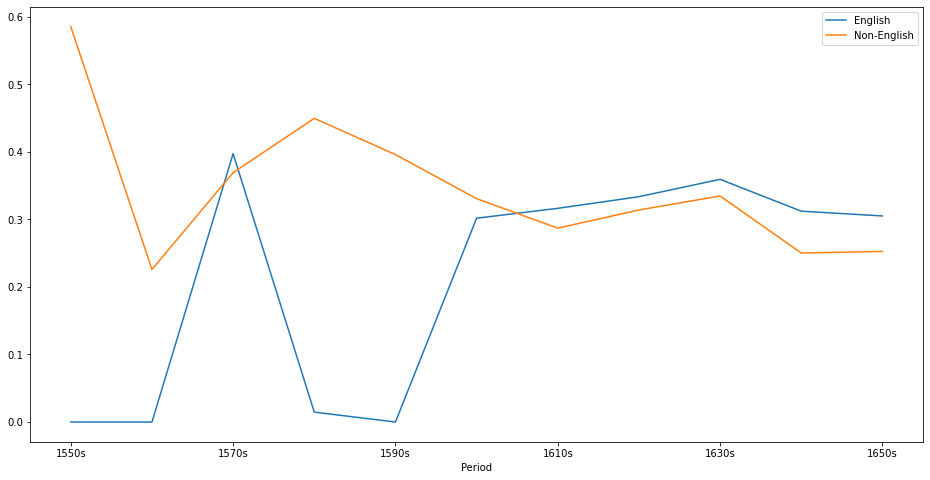

In [103]:
closeness_en_df[1:].plot.line(figsize = (16, 8))

In [104]:
ttesting(closeness_en_list, closeness_en_df)

,English,Non-English
Period,,
All,[1],[]
1550s,[],[]
1560s,[],[]
1570s,[],[]
1580s,[],[0]
1590s,[],[]
1600s,[],[0]
1610s,[1],[]
1620s,[1],[]


In [105]:
# calculate eigenvector centrality
G_eigen = nx.Graph()
edge_list = [
            (all_network_edge['Source'][i], all_network_edge['Target'][i])
            for i in range(0, len(all_network_edge))
        ]
G_eigen.add_edges_from(edge_list)
eigenvector_full = nx.eigenvector_centrality(G_eigen)

In [107]:
eigen_cal_list = []
for period in periods:
    G_eigen = nx.Graph()
    eigen_df = all_network_edge.loc[all_network_edge['Publication Period'] == period].reset_index(drop = True)
    edge_list = [
                (eigen_df['Source'][i], eigen_df['Target'][i])
                for i in range(0, len(eigen_df))
            ]
    G_eigen.add_edges_from(edge_list)
    eigenvector = nx.eigenvector_centrality(G_eigen, max_iter = 500)
    eigen_cal_list.append(eigenvector)

In [108]:
len(eigen_cal_list) == len(periods)

True

In [109]:
eigenvector_df = pd.DataFrame()
eigenvector_list = pd.DataFrame()
eigenvector_df['Period'] = ['All'] + periods
eigenvector_list['Period'] = ['All'] + periods

for l in languages:
    eigenvector_lan = []
    eigenvector_num = []
    
    if l == 'All':
        temp_df = all_network_edge
    else:
        temp_df = all_network_edge.loc[all_network_edge['Language'] == l].reset_index(drop = True)
    id_list = [ID for ID in temp_df['Source']] + [ID for ID in temp_df['Target']]
    id_list = list(set(id_list))
    eigenvector_all = [eigenvector_full[ID] for ID in id_list]
    eigenvector_num.append(eigenvector_all)
    
    if len(eigenvector_all) == 0:
        eigenvector_lan.append(0)
    else:
        eigenvector_lan.append(sum(eigenvector_all) / len(eigenvector_all))
    
    for i in range(0, len(periods)):
        temp_df_p = temp_df.loc[temp_df['Publication Period'] == periods[i]].reset_index(drop = True)
        id_list_p = [ID for ID in temp_df_p['Source']] + [ID for ID in temp_df_p['Target']]
        id_list_p = list(set(id_list_p))
        eigenvector_all_p = [eigen_cal_list[i][ID] for ID in id_list_p]
        eigenvector_num.append(eigenvector_all_p)
        
        if len(eigenvector_all_p) == 0:
            eigenvector_lan.append(0)
        else:
            eigenvector_lan.append(sum(eigenvector_all_p) / len(eigenvector_all_p))
    
    eigenvector_df[l] = eigenvector_lan
    eigenvector_list[l] = eigenvector_num

eigenvector_df = eigenvector_df.set_index('Period')
eigenvector_list = eigenvector_list.set_index('Period')

In [110]:
eigenvector_df.round(4)

,All,DUTCH,ENGLISH,FRENCH,LATIN,SPANISH
Period,,,,,,
All,0.0113,0.0440,0.0275,0.0203,0.0119,0.0188
1550s,0.3008,0.0000,0.0000,0.0000,0.3643,0.3262
1560s,0.0418,0.1668,0.0000,0.1867,0.0370,0.0000
1570s,0.0672,0.1875,0.0562,0.1247,0.0429,0.0151
1580s,0.0701,0.0000,0.0000,0.0986,0.0715,0.0000
1590s,0.0501,0.0000,0.0000,0.0601,0.0463,0.2434
1600s,0.0255,0.0000,0.0341,0.0460,0.0238,0.0332
1610s,0.0224,0.0000,0.0495,0.0370,0.0236,0.0000
1620s,0.0233,0.0596,0.0558,0.0434,0.0242,0.0486


In [111]:
ttesting(eigenvector_list, eigenvector_df)

C:\Users\User\AppData\Local\Temp\ipykernel_15644\1464152683.py:19: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_statistic, p_value = ttest_ind(list(df[df.columns[i]][row]), list(df[df.columns[j]][row]))


,All,DUTCH,ENGLISH,FRENCH,LATIN,SPANISH
Period,,,,,,
All,"[, , , , ]","[0, , 3, 4, ]","[0, , 3, 4, ]","[0, , , 4, ]","[, , , , ]","[, , , , ]"
1550s,"[, , , , ]","[, , , , ]","[, , , , ]","[, , , , ]","[, , , , ]","[, , , , ]"
1560s,"[, , , , ]","[0, , , 4, 5]","[, , , , ]","[0, , , 4, 5]","[, , , , ]","[, , , , ]"
1570s,"[, , , 4, ]","[0, , , 4, 5]","[, , , , ]","[0, , 2, 4, 5]","[, , , , ]","[, , , , ]"
1580s,"[, , , , ]","[, , , , ]","[, 1, , , ]","[0, , 2, , ]","[, , , , ]","[, , , , ]"
1590s,"[, , , , ]","[, , , , ]","[, , , , ]","[, , , , ]","[, , , , ]","[0, , , 3, 4]"
1600s,"[, , , , ]","[, , , , ]","[, , , , ]","[0, , , 4, ]","[, , , , ]","[, , , , ]"
1610s,"[, , , , ]","[, , , , ]","[0, , , 4, ]","[0, , , 4, ]","[, , , , ]","[, , , , ]"
1620s,"[, , , , ]","[, , , , ]","[0, , , 4, ]","[0, , , 4, ]","[, , , , ]","[, , , , ]"


In [112]:
test_result = eigenvector_list[['All', 'ENGLISH']][7:11]

In [113]:
test_result

,All,ENGLISH
Period,,
1610s,"[0.01664050405379496, 0.002079478341981996, 0....","[0.02772346059739292, 0.012987998279800675, 0...."
1620s,"[0.02597236704385247, 0.017489326535330873, 0....","[0.06198426263500223, 0.16842615385596704, 0.0..."
1630s,"[0.010430592063310113, 0.007317028882610391, 0...","[0.023007198136179536, 0.024708556684116763, 0..."
1640s,"[0.008103580732096646, 0.03450377487086171, 0....","[0.19139223792480342, 0.03785409333971361, 0.0..."


In [114]:
for i in range(0, len(test_result)):
    print(ttest_ind(test_result['All'][i], test_result['ENGLISH'][i]))

Ttest_indResult(statistic=-4.869407549305829, pvalue=1.4119477456736856e-06)
Ttest_indResult(statistic=-5.652487021664569, pvalue=2.3330207968933294e-08)
Ttest_indResult(statistic=-3.320632602186143, pvalue=0.0009665732296700679)
Ttest_indResult(statistic=-2.407591043318058, pvalue=0.01695280281417027)


In [115]:
nodes_list = [ID for ID in eigenvector_full]
only_nodes = per.loc[per['ODIS_PERS_ID'].isin(nodes_list)]
only_en = per.loc[(per['ENGLISH'] > 0) & (per['ODIS_PERS_ID'].isin(nodes_list))]
en_id_list = [ID for ID in only_en['ODIS_PERS_ID']]
nonen_id_list = [ID for ID in only_nodes['ODIS_PERS_ID'] if not ID in en_id_list]

In [116]:
len(en_id_list) + len(nonen_id_list) == len(only_nodes)

True

In [117]:
eigenvector_en_df = pd.DataFrame()
eigenvector_en_list = pd.DataFrame()
eigenvector_en_df['Period'] = ['All'] + periods
eigenvector_en_list['Period'] = ['All'] + periods

eigenvector_en_lan = []
eigenvector_nonen_lan = []

eigenvector_en_num = []
eigenvector_nonen_num = []

eigenvector_en_all = [eigenvector_full[ID] for ID in en_id_list]
eigenvector_en_num.append(eigenvector_en_all)

eigenvector_nonen_all = [eigenvector_full[ID] for ID in nonen_id_list]
eigenvector_nonen_num.append(eigenvector_nonen_all)


if len(eigenvector_en_all) == 0:
    eigenvector_en_lan.append(0)
else:
    eigenvector_en_lan.append(sum(eigenvector_en_all) / len(eigenvector_en_all))
    
if len(eigenvector_nonen_all) == 0:
    eigenvector_nonen_lan.append(0)
else:
    eigenvector_nonen_lan.append(sum(eigenvector_nonen_all) / len(eigenvector_nonen_all))

for i in range(0, len(periods)):
    temp_df = all_network_edge.loc[all_network_edge['Publication Period'] == periods[i]]
    temp_id = [ID for ID in temp_df['Source']] + [ID for ID in temp_df['Target']]
    temp_id = list(set(temp_id))
    
    temp_en_df = temp_df.loc[temp_df['Language'] == 'ENGLISH']
    temp_en_id = [ID for ID in temp_en_df['Source']] + [ID for ID in temp_en_df['Target']]
    temp_en_id = list(set(temp_en_id))
    temp_nonen_id = [ID for ID in temp_id if not ID in temp_en_id]
    
    eigenvector_en_all_p = [eigen_cal_list[i][ID] for ID in temp_en_id]
    eigenvector_en_num.append(eigenvector_en_all_p)
    
    eigenvector_nonen_all_p = [eigen_cal_list[i][ID] for ID in temp_nonen_id]
    eigenvector_nonen_num.append(eigenvector_nonen_all_p)
    
    if len(eigenvector_en_all_p) == 0:
        eigenvector_en_lan.append(0)
    else:
        eigenvector_en_lan.append(sum(eigenvector_en_all_p) / len(eigenvector_en_all_p))
        
    if len(eigenvector_nonen_all_p) == 0:
        eigenvector_nonen_lan.append(0)
    else:
        eigenvector_nonen_lan.append(sum(eigenvector_nonen_all_p) / len(eigenvector_nonen_all_p))

eigenvector_en_df['English'] = eigenvector_en_lan
eigenvector_en_df['Non-English'] = eigenvector_nonen_lan

eigenvector_en_list['English'] = eigenvector_en_num
eigenvector_en_list['Non-English'] = eigenvector_nonen_num

eigenvector_en_df = eigenvector_en_df.set_index('Period')
eigenvector_en_list = eigenvector_en_list.set_index('Period')

In [118]:
eigenvector_en_df.round(4)

,English,Non-English
Period,,
All,0.0268,0.0096
1550s,0.0000,0.3008
1560s,0.0000,0.0418
1570s,0.0562,0.0680
1580s,0.0000,0.0722
1590s,0.0000,0.0501
1600s,0.0341,0.0245
1610s,0.0495,0.0198
1620s,0.0558,0.0208


<AxesSubplot:xlabel='Period'>

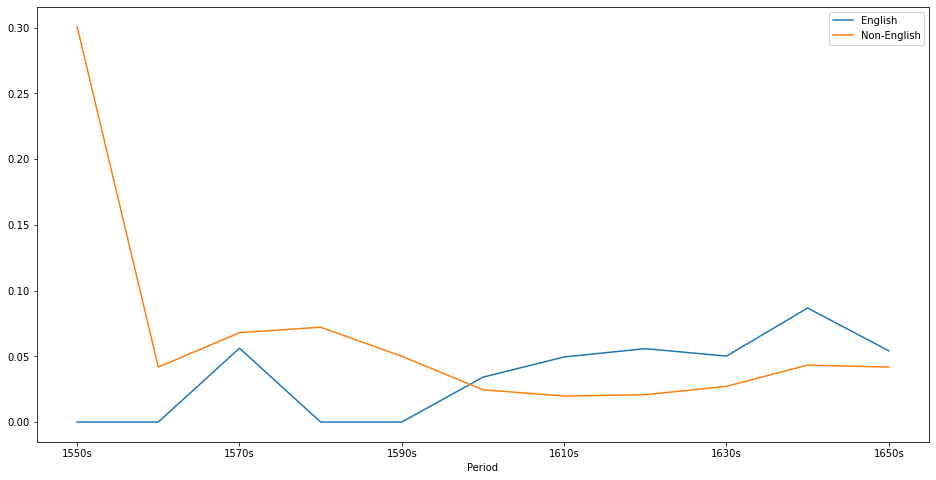

In [119]:
eigenvector_en_df[1:].plot.line(figsize = (16, 8))

In [120]:
ttesting(eigenvector_en_list, eigenvector_en_df)

,English,Non-English
Period,,
All,[1],[]
1550s,[],[]
1560s,[],[]
1570s,[],[]
1580s,[],[]
1590s,[],[]
1600s,[],[]
1610s,[1],[]
1620s,[1],[]


In [121]:
decades = ['All'] + periods
for i in range(0, len(decades)):
    print(decades[i], len(eigenvector_en_num[i]))

All 201
1550s 0
1560s 0
1570s 7
1580s 3
1590s 0
1600s 52
1610s 51
1620s 45
1630s 58
1640s 12
1650s 13


In [122]:
decades = ['All'] + periods
for i in range(0, len(decades)):
    print(decades[i], len(eigenvector_nonen_num[i]))

All 1860
1550s 9
1560s 97
1570s 94
1580s 104
1590s 184
1600s 447
1610s 540
1620s 588
1630s 366
1640s 181
1650s 132


In [123]:
decades = ['All'] + periods
for i in range(0, len(eigenvector_en_list)):
    print(decades[i], ttest_ind(eigenvector_en_list['English'][i], eigenvector_en_list['Non-English'][i]))

All Ttest_indResult(statistic=12.65271267637491, pvalue=2.163700150644167e-35)
1550s Ttest_indResult(statistic=nan, pvalue=nan)
1560s Ttest_indResult(statistic=nan, pvalue=nan)
1570s Ttest_indResult(statistic=-0.40645199084086175, pvalue=0.6852878248892424)
1580s Ttest_indResult(statistic=-1.8645368494854488, pvalue=0.06503926103356696)
1590s Ttest_indResult(statistic=nan, pvalue=nan)
1600s Ttest_indResult(statistic=1.7845522609134714, pvalue=0.074943839088152)
1610s Ttest_indResult(statistic=6.046765371656813, pvalue=2.6256623108658293e-09)
1620s Ttest_indResult(statistic=7.31208517441216, pvalue=8.003194190084125e-13)
1630s Ttest_indResult(statistic=4.37614516542938, pvalue=1.5244341277562583e-05)
1640s Ttest_indResult(statistic=2.666652235308115, pvalue=0.008318173575428061)
1650s Ttest_indResult(statistic=0.5955747149726769, pvalue=0.5524007933168266)


In [124]:
all_eigen = {}
for period in periods:
    period_df = meta.loc[meta['Publication Period'] == period]
    ID_list = list(set([i for i in period_df['ODIS_PERS_ID']]))
    all_eigen[period] = len(ID_list)
#     print(period, len(ID_list))

In [125]:
all_eigen

{'1550s': 9,
 '1560s': 97,
 '1570s': 101,
 '1580s': 108,
 '1590s': 186,
 '1600s': 503,
 '1610s': 595,
 '1620s': 640,
 '1630s': 427,
 '1640s': 197,
 '1650s': 152}

In [126]:
en_eigen = {}
eng_nodes = meta.loc[meta['Language'] == 'ENGLISH']
for period in periods:
    period_df = eng_nodes.loc[eng_nodes['Publication Period'] == period]
    ID_list = list(set([i for i in period_df['ODIS_PERS_ID']]))
    en_eigen[period] = len(ID_list)
#     print(period, len(ID_list))

In [127]:
en_eigen

{'1550s': 0,
 '1560s': 0,
 '1570s': 7,
 '1580s': 3,
 '1590s': 2,
 '1600s': 53,
 '1610s': 51,
 '1620s': 47,
 '1630s': 58,
 '1640s': 13,
 '1650s': 16}

In [128]:
for period in periods:
    print(period, all_eigen[period] - en_eigen[period])

1550s 9
1560s 97
1570s 94
1580s 105
1590s 184
1600s 450
1610s 544
1620s 593
1630s 369
1640s 184
1650s 136


In [129]:
eigenvector_df.T.round(4)

Period,All,1550s,1560s,1570s,1580s,1590s,1600s,1610s,1620s,1630s,1640s,1650s
All,0.0113,0.3008,0.0418,0.0672,0.0701,0.0501,0.0255,0.0224,0.0233,0.0303,0.0460,0.0429
DUTCH,0.0440,0.0000,0.1668,0.1875,0.0000,0.0000,0.0000,0.0000,0.0596,0.1840,0.0000,0.0093
ENGLISH,0.0275,0.0000,0.0000,0.0562,0.0000,0.0000,0.0341,0.0495,0.0558,0.0502,0.0867,0.0542
FRENCH,0.0203,0.0000,0.1867,0.1247,0.0986,0.0601,0.0460,0.0370,0.0434,0.0436,0.0694,0.0206
LATIN,0.0119,0.3643,0.0370,0.0429,0.0715,0.0463,0.0238,0.0236,0.0242,0.0343,0.0471,0.0619
SPANISH,0.0188,0.3262,0.0000,0.0151,0.0000,0.2434,0.0332,0.0000,0.0486,0.0000,0.0000,0.0000


In [130]:
ttesting(eigenvector_list.T, eigenvector_df.T)

C:\Users\User\AppData\Local\Temp\ipykernel_15644\1464152683.py:19: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_statistic, p_value = ttest_ind(list(df[df.columns[i]][row]), list(df[df.columns[j]][row]))


Period,All,1550s,1560s,1570s,1580s,1590s,1600s,1610s,1620s,1630s,1640s,1650s
All,"[, , , , , , , , , , ]","[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","[0, , , , , 6, 7, 8, , , ]","[0, , 2, , 5, 6, 7, 8, 9, 10, 11]","[0, , 2, , 5, 6, 7, 8, 9, 10, 11]","[0, , , , , 6, 7, 8, 9, , ]","[0, , , , , , , , , , ]","[0, , , , , , , , , , ]","[0, , , , , , , , , , ]","[0, , , , , , , 7, 8, , ]","[0, , , , , , 6, 7, 8, 9, ]","[0, , , , , , 6, 7, 8, 9, ]"
DUTCH,"[, , , , , , , , , , ]","[, , , , , , , , , , ]","[0, , , , , , , , , , 11]","[0, , , , , , , , , , 11]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , 11]","[, , , , , , , , , , 11]","[, , , , , , , , , , ]","[, , , , , , , , , , ]"
ENGLISH,"[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[0, , , , , , , , , , ]","[0, , , , , , , , , , ]","[0, , , , , , , , , , ]","[0, , , , , , 6, , , , ]","[, , , , , , , , , , ]"
FRENCH,"[, , , , , , , , , , ]","[, , , , , , , , , , ]","[0, , 3, 4, 5, 6, 7, 8, 9, 10, 11]","[0, , , , 5, 6, 7, 8, 9, 10, 11]","[0, , , , 5, 6, 7, 8, 9, 10, 11]","[0, , , , , 6, 7, 8, 9, , 11]","[0, , , , , , , , , , 11]","[0, , , , , , , , , , 11]","[0, , , , , , , , , , 11]","[0, , , , , , , , , , 11]","[0, , , , , , 6, 7, 8, 9, 11]","[, , , , , , , , , , ]"
LATIN,"[, , , , , , , , , , ]","[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","[0, , , , , , 7, 8, , , ]","[0, , , , , 6, 7, 8, , , ]","[0, , 2, 3, 5, 6, 7, 8, 9, 10, ]","[0, , , , , 6, 7, 8, 9, , ]","[0, , , , , , , , , , ]","[0, , , , , , , , , , ]","[0, , , , , , , , , , ]","[0, , , , , , 6, 7, 8, , ]","[0, , , , , , 6, 7, 8, 9, ]","[0, , , , , , 6, 7, 8, 9, ]"
SPANISH,"[, , , , , , , , , , ]","[0, 2, 3, , , 6, , 8, , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[0, , 2, 3, , , , , , , ]","[, , 2, , , , , , , , ]","[, , , , , , , , , , ]","[, , 2, , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]"


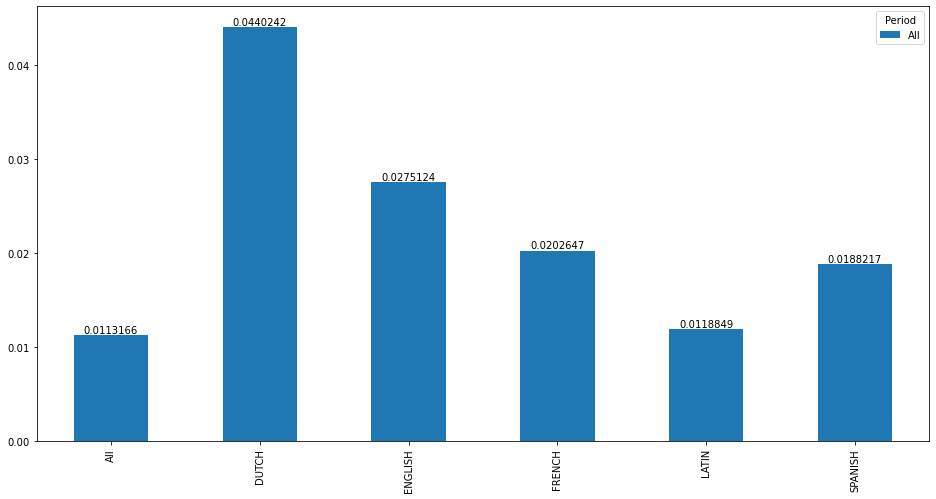

In [131]:
eigenvector_plot = eigenvector_df.iloc[:1].T.plot.bar(figsize = (16, 8))

for container in eigenvector_plot.containers:
    eigenvector_plot.bar_label(container)

<AxesSubplot:xlabel='Period'>

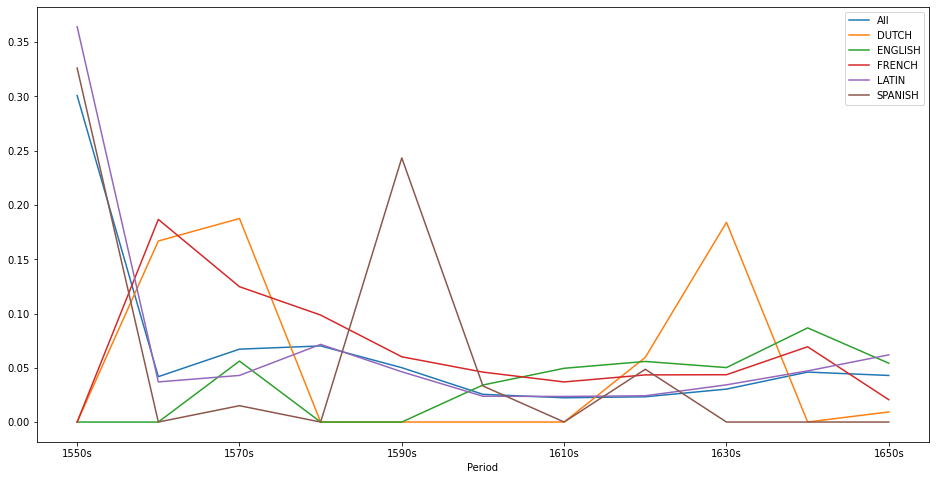

In [132]:
eigenvector_df.iloc[1:].plot.line(figsize = (16, 8))

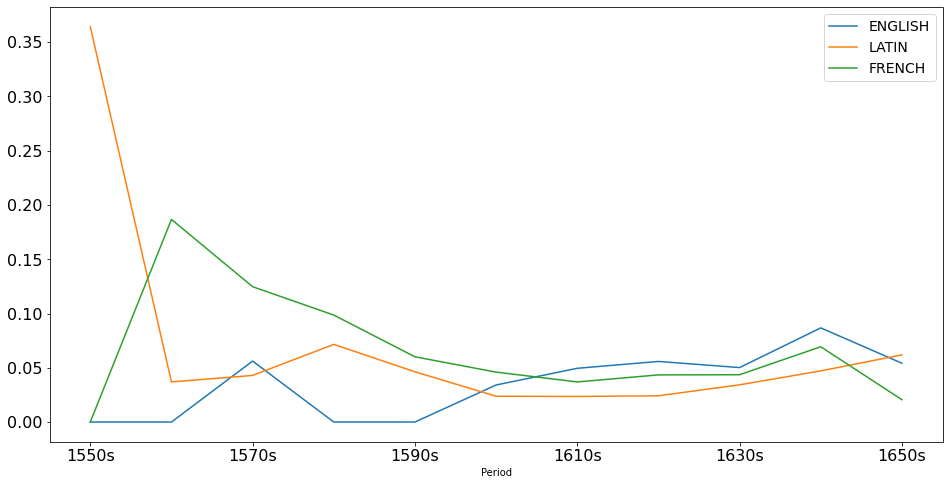

In [133]:
eigenvector_df_plot = eigenvector_df.iloc[1:][['ENGLISH', 'LATIN', 'FRENCH']].plot.line(figsize = (16, 8))
eigenvector_df_plot.tick_params(axis='x', labelsize = 16)
eigenvector_df_plot.tick_params(axis='y', labelsize = 16)
eigenvector_df_plot.legend(fontsize = 14)

In [134]:
# calculate density
def den(node, edge):
    G = nx.Graph()
    
#     node_list = [ID for ID in node['id']]
    edge_list = [
        (edge['Source'][i], edge['Target'][i])
        for i in range(0, len(edge))
    ]
#     G.add_nodes_from(node_list)
    G.add_edges_from(edge_list)
    density = [nx.density(G)]
    density_act = [nx.number_of_edges(G)]
    density_pos = [(len(G) * (len(G) - 1)) / 2]
    
    for p in periods:
        G_period = nx.Graph()
        
#         period_node = node.loc[node[p] > 0].reset_index(drop = True)
        period_edge = edge.loc[edge['Publication Period'] == p].reset_index(drop = True)
        
#         period_node_list = [ID for ID in period_node['id']]
        period_edge_list = [
            (period_edge['Source'][i], period_edge['Target'][i])
            for i in range(0, len(period_edge))
        ]
#         G_period.add_nodes_from(period_node_list)
        G_period.add_edges_from(period_edge_list)
        density.append(nx.density(G_period))
        density_act.append(nx.number_of_edges(G_period))
        density_pos.append((len(G_period) * (len(G_period) - 1)) / 2)
    
    return density, density_act, density_pos

In [135]:
density_df = pd.DataFrame()
density_df['Period'] = ['All'] + periods
density_df['All'] = den(all_network_node, all_network_edge)[0]
density_df['Dutch'] = den(du_network_node, du_network_edge)[0]
density_df['English'] = den(en_network_node, en_network_edge)[0]
density_df['French'] = den(fr_network_node, fr_network_edge)[0]
density_df['Latin'] = den(la_network_node, la_network_edge)[0]
density_df['Spanish'] = den(sp_network_node, sp_network_edge)[0]
density_df = density_df.set_index('Period')

In [136]:
density_df.round(2)

,All,Dutch,English,French,Latin,Spanish
Period,,,,,,
All,0.00,0.10,0.03,0.01,0.00,0.10
1550s,0.22,0.00,0.00,0.00,0.50,0.33
1560s,0.04,0.40,0.00,0.42,0.04,0.16
1570s,0.09,1.00,0.52,0.29,0.10,0.25
1580s,0.09,1.00,0.67,0.18,0.12,0.00
1590s,0.04,0.00,0.00,0.06,0.06,1.00
1600s,0.01,0.00,0.07,0.04,0.01,1.00
1610s,0.01,0.00,0.10,0.04,0.01,0.00
1620s,0.01,1.00,0.10,0.03,0.01,1.00


In [137]:
density_en_df = pd.DataFrame()
density_en_df['English'] = den(en_network_node, en_network_edge)[0]
density_en_df['Non-English'] = den(nonen_network_node, nonen_network_edge)[0]

In [138]:
density_en_df.round(4)

,English,Non-English
0,0.0319,0.0037
1,0.0000,0.2222
2,0.0000,0.0402
3,0.5238,0.0990
4,0.6667,0.0898
5,0.0000,0.0383
6,0.0701,0.0120
7,0.0980,0.0104
8,0.0980,0.0091
9,0.0950,0.0177


<AxesSubplot:>

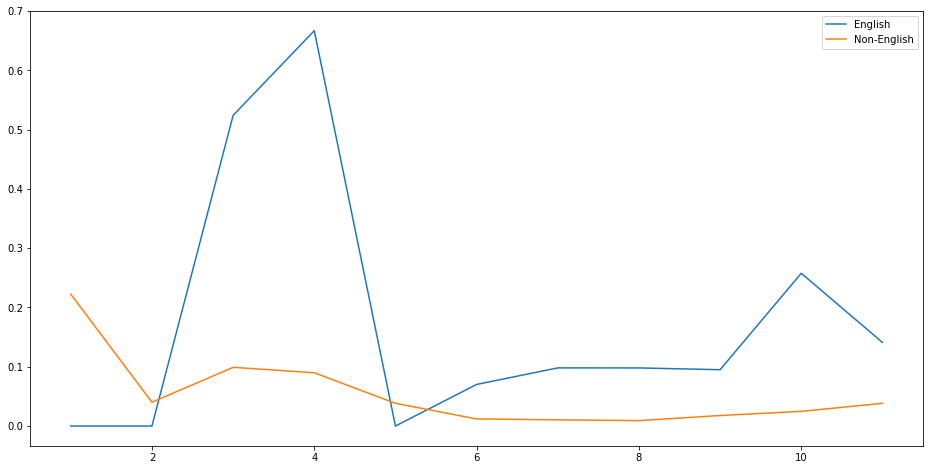

In [139]:
density_en_df[1:].plot.line(figsize = (16, 8))

In [140]:
density_act = pd.DataFrame()
density_act['Period'] = ['All'] + periods
density_act['All'] = den(all_network_node, all_network_edge)[1]
density_act['Dutch'] = den(du_network_node, du_network_edge)[1]
density_act['English'] = den(en_network_node, en_network_edge)[1]
density_act['French'] = den(fr_network_node, fr_network_edge)[1]
density_act['Latin'] = den(la_network_node, la_network_edge)[1]
density_act['Spanish'] = den(sp_network_node, sp_network_edge)[1]
density_act = density_act.set_index('Period')

In [141]:
density_act

,All,Dutch,English,French,Latin,Spanish
Period,,,,,,
All,7548,25,463,2855,4542,31
1550s,8,0,0,0,3,5
1560s,187,4,0,57,122,15
1570s,469,6,11,305,155,7
1580s,483,1,2,314,182,0
1590s,645,0,0,508,161,1
1600s,1362,0,93,690,627,3
1610s,1745,0,125,586,1087,0
1620s,1767,1,97,441,1303,6


In [142]:
density_pos = pd.DataFrame()
density_pos['Period'] = ['All'] + periods
density_pos['All'] = den(all_network_node, all_network_edge)[2]
density_pos['Dutch'] = den(du_network_node, du_network_edge)[2]
density_pos['English'] = den(en_network_node, en_network_edge)[2]
density_pos['French'] = den(fr_network_node, fr_network_edge)[2]
density_pos['Latin'] = den(la_network_node, la_network_edge)[2]
density_pos['Spanish'] = den(sp_network_node, sp_network_edge)[2]
density_pos = density_pos.set_index('Period')

In [143]:
density_pos

,All,Dutch,English,French,Latin,Spanish
Period,,,,,,
All,2122830.0,253.0,14535.0,239778.0,1109305.0,300.0
1550s,36.0,0.0,0.0,0.0,6.0,15.0
1560s,4656.0,10.0,0.0,136.0,2926.0,91.0
1570s,5050.0,6.0,21.0,1035.0,1540.0,28.0
1580s,5671.0,1.0,3.0,1711.0,1540.0,0.0
1590s,16836.0,0.0,0.0,8646.0,2701.0,1.0
1600s,124251.0,0.0,1326.0,17578.0,49455.0,3.0
1610s,174345.0,0.0,1275.0,14878.0,93528.0,0.0
1620s,200028.0,1.0,990.0,13041.0,127765.0,6.0


In [144]:
def ztesting_den(df, df2, df3):
    
    df_new = df.copy()
    
    for i in range(0, len(df.columns)):
        result_list = []
        
        for row in range(0, len(df)):
            result_set = []
            
            if str(df[df.columns[i]][row]) == 'nan':
                result_list.append(None)
            else:
                for j in range(0, len(df.columns)):
                    if not i == j:
                        if str(df[df.columns[j]][row]) == 'nan':
                            result_set.append('n')
                        else:
                            z_score, p_value = proportions_ztest(
                                    [df[df.columns[i]][row], df[df.columns[j]][row]], [df2[df2.columns[i]][row], df2[df2.columns[j]][row]]
                                )
                            if p_value < 0.05:
                                if max([df3[df3.columns[i]][row], df3[df3.columns[j]][row]]) == df3[df3.columns[i]][row]:
                                    result_set.append(j)
                                else:
                                    result_set.append('')
                            else:
                                result_set.append('')

                result_list.append(result_set)
        
        df_new[df.columns[i]] = result_list
    
    return df_new

In [145]:
ztesting_den(density_act, density_pos, density_df)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\proportion.py:839: RuntimeWarning: invalid value encountered in divide
  prop = count * 1. / nobs
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\proportion.py:855: RuntimeWarning: divide by zero encountered in divide
  nobs_fact = np.sum(1. / nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\proportion.py:853: RuntimeWarning: invalid value encountered in scalar divide
  p_pooled = np.sum(count) * 1. / np.sum(nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\proportion.py:858: RuntimeWarning: invalid value encountered in scalar multiply
  var_ = p_pooled * (1 - p_pooled) * nobs_fact
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\weightstats.py:790: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std


,All,Dutch,English,French,Latin,Spanish
Period,,,,,,
All,"[, , , , ]","[0, 2, 3, 4, ]","[0, , 3, 4, ]","[0, , , 4, ]","[0, , , , ]","[0, , 2, 3, 4]"
1550s,"[, , , , ]","[, , , , ]","[, , , , ]","[, , , , ]","[, , , , ]","[, , , , ]"
1560s,"[, , , , ]","[0, , , 4, ]","[, , , , ]","[0, , , 4, 5]","[, , , , ]","[0, , , , 4]"
1570s,"[, , , , ]","[0, 2, 3, 4, 5]","[0, , 3, 4, 5]","[0, , , 4, ]","[, , , , ]","[0, , , , 4]"
1580s,"[, , , , ]","[0, , 3, 4, ]","[0, , 3, 4, ]","[0, , , 4, ]","[0, , , , ]","[, , , , ]"
1590s,"[, , , , ]","[, , , , ]","[, , , , ]","[0, , , , ]","[0, , , , ]","[0, , , 3, 4]"
1600s,"[, , , , ]","[, , , , ]","[0, , 3, 4, ]","[0, , , 4, ]","[0, , , , ]","[0, , 2, 3, 4]"
1610s,"[, , , , ]","[, , , , ]","[0, , 3, 4, ]","[0, , , 4, ]","[0, , , , ]","[, , , , ]"
1620s,"[, , , , ]","[0, 2, 3, 4, ]","[0, , 3, 4, ]","[0, , , 4, ]","[0, , , , ]","[0, , 2, 3, 4]"


In [146]:
ztesting_den(density_act.T, density_pos.T, density_df.T)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\proportion.py:839: RuntimeWarning: invalid value encountered in divide
  prop = count * 1. / nobs
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\proportion.py:855: RuntimeWarning: divide by zero encountered in divide
  nobs_fact = np.sum(1. / nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\proportion.py:858: RuntimeWarning: invalid value encountered in scalar multiply
  var_ = p_pooled * (1 - p_pooled) * nobs_fact
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\proportion.py:853: RuntimeWarning: invalid value encountered in scalar divide
  p_pooled = np.sum(count) * 1. / np.sum(nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\weightstats.py:790: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std


Period,All,1550s,1560s,1570s,1580s,1590s,1600s,1610s,1620s,1630s,1640s,1650s
All,"[, , , , , , , , , , ]","[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","[0, , , , , 6, 7, 8, 9, 10, ]","[0, , 2, , 5, 6, 7, 8, 9, 10, 11]","[0, , 2, , 5, 6, 7, 8, 9, 10, 11]","[0, , , , , 6, 7, 8, 9, 10, ]","[0, , , , , , 7, 8, , , ]","[0, , , , , , , 8, , , ]","[0, , , , , , , , , , ]","[0, , , , , , 6, 7, 8, , ]","[0, , , , , , 6, 7, 8, 9, ]","[0, , , , , , 6, 7, 8, 9, 10]"
Dutch,"[, , , , , , , , , , ]","[, , , , , , , , , , ]","[0, , , , , , , , , , ]","[0, , 2, , , , , , , , 11]","[0, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[0, , , , , , , , , , ]","[0, , , , , , , , , , ]","[, , , , , , , , , , ]","[0, , , , , , , , , , ]"
English,"[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[0, , , , , 6, 7, 8, 9, 10, 11]","[0, , , , , 6, 7, 8, 9, , 11]","[, , , , , , , , , , ]","[0, , , , , , , , , , ]","[0, , , , , , 6, , , , ]","[0, , , , , , 6, , , , ]","[0, , , , , , 6, , , , ]","[0, , , , , , 6, 7, 8, 9, ]","[0, , , , , , 6, , , , ]"
French,"[, , , , , , , , , , ]","[, , , , , , , , , , ]","[0, , 3, 4, 5, 6, 7, 8, 9, 10, 11]","[0, , , 4, 5, 6, 7, 8, 9, 10, 11]","[0, , , , 5, 6, 7, 8, 9, 10, 11]","[0, , , , , 6, 7, 8, 9, , ]","[0, , , , , , , 8, , , ]","[0, , , , , , , 8, , , ]","[0, , , , , , , , , , ]","[0, , , , , , , , 8, , ]","[0, , , , , , 6, 7, 8, 9, ]","[0, , , , , , 6, 7, 8, 9, ]"
Latin,"[, , , , , , , , , , ]","[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","[0, , , , , 6, 7, 8, 9, 10, ]","[0, , 2, , 5, 6, 7, 8, 9, 10, 11]","[0, , 2, , 5, 6, 7, 8, 9, 10, 11]","[0, , 2, , , 6, 7, 8, 9, 10, ]","[0, , , , , , , 8, , , ]","[0, , , , , , , 8, , , ]","[0, , , , , , , , , , ]","[0, , , , , , 6, 7, 8, , ]","[0, , , , , , 6, 7, 8, 9, ]","[0, , 2, , , , 6, 7, 8, 9, 10]"
Spanish,"[, , , , , , , , , , ]","[0, , , , , , , , , , ]","[, , , , , , , , , , ]","[0, , , , , , , , , , ]","[, , , , , , , , , , ]","[0, , 2, , , , , , , , ]","[0, 1, 2, 3, , , , , , , ]","[, , , , , , , , , , ]","[0, 1, 2, 3, , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]","[, , , , , , , , , , ]"


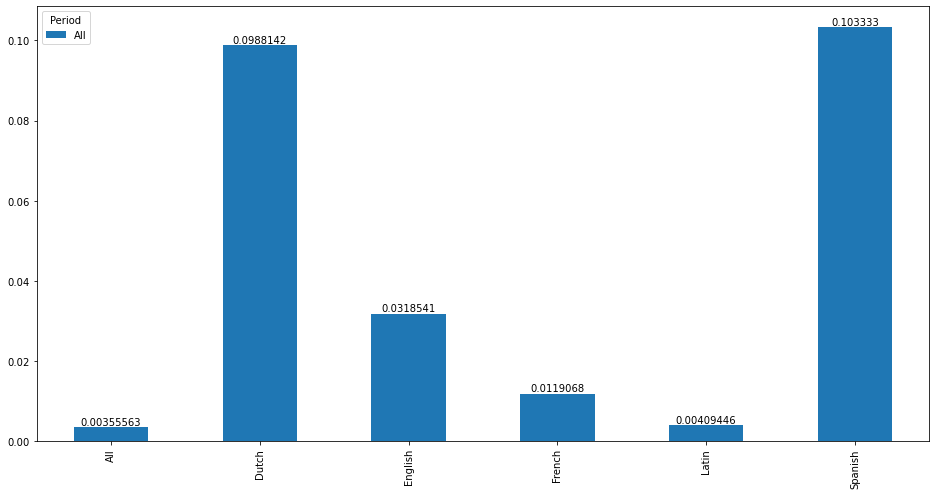

In [147]:
density_plot = density_df.iloc[:1].T.plot.bar(figsize = (16, 8))

for container in density_plot.containers:
    density_plot.bar_label(container)

<AxesSubplot:xlabel='Period'>

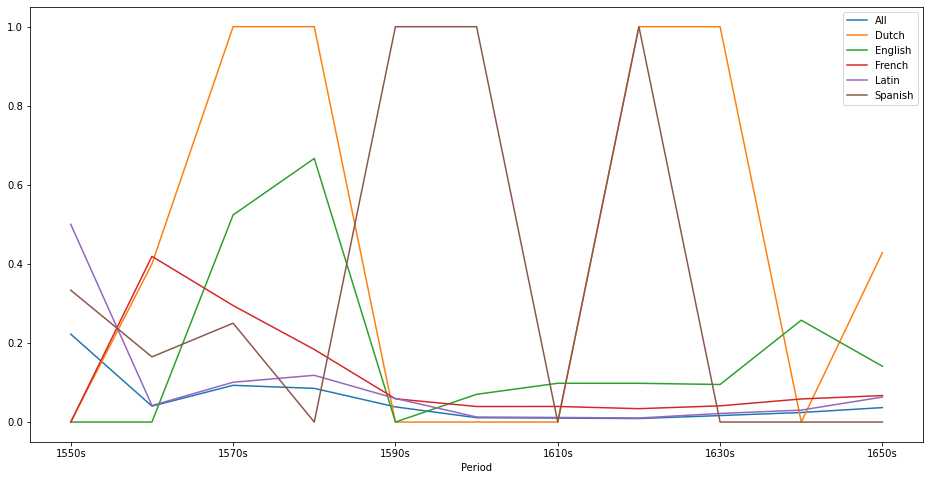

In [148]:
density_df.iloc[1:].plot.line(figsize = (16, 8))

<AxesSubplot:xlabel='Period'>

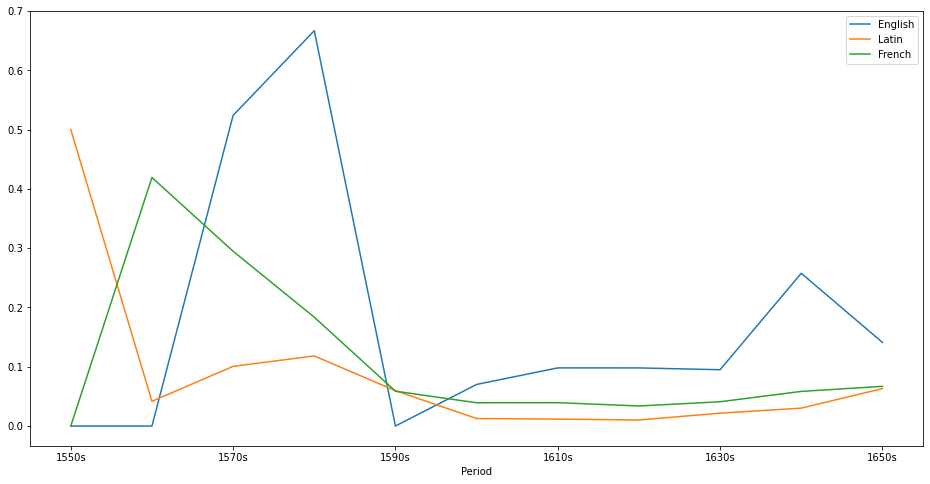

In [149]:
density_df.iloc[1:][['English', 'Latin', 'French']].plot.line(figsize = (16, 8))

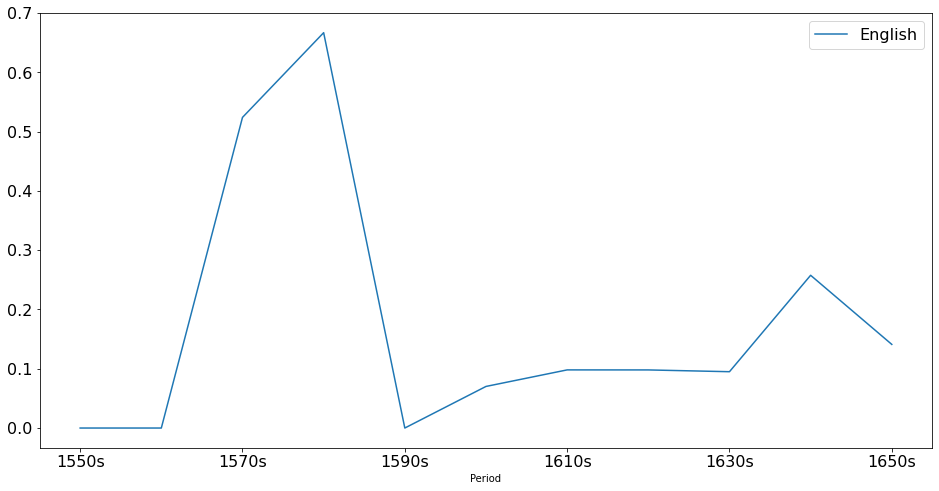

In [150]:
density_plot = density_df.iloc[1:][['English']].plot.line(figsize = (16, 8))
density_plot.tick_params(axis='x', labelsize = 16)
density_plot.tick_params(axis='y', labelsize = 16)
density_plot.legend(fontsize = 16)

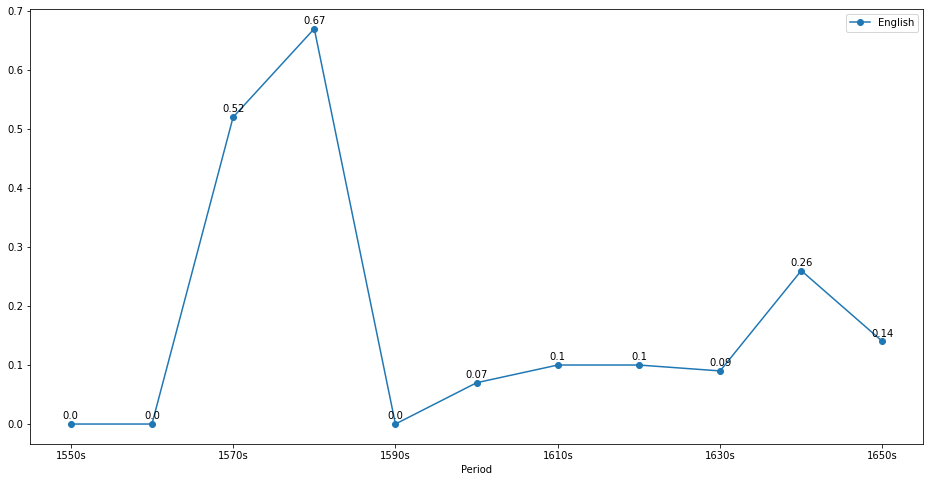

In [151]:
density_line_df = density_df.iloc[1:][['English']].round(2)
density_line = density_line_df.plot.line(figsize = (16, 8), marker = 'o', linestyle = '-')

for column in density_line_df.columns:
    for i, value in enumerate(density_line_df[column]):
        density_line.annotate(value, (i, value), textcoords = "offset points", xytext = (0, 5), ha = 'center')